This code is an example for Multi-MNIST-Sudokus.

Firstly, we need to generate the mixed sudokus used to solved by our model. Dataset will be download automaticlly.

In [1]:
from collections import defaultdict
import mnist
import random
import numpy as np
import sys
from skimage.transform import resize

def rescale(x):
    x = np.asarray(x)
    x = x.reshape(16, 1, 28, 28)
    x = np.transpose(x, (1, 2, 3, 0))
    x = resize(x, (1, 32, 32, 16))
    x = np.transpose(x, (3, 0, 1, 2))
    for i in range(16):
        x[i][0] = (x[i][0] - 0.5) / 0.5
        
    return x


In [2]:
def gen_data(n, dtype, seed):
    seed = seed
    np.random.seed(seed)
    if ("5" in dtype):
        diff_num = True
    else:
        diff_num = False
        
    sudokus = np.load("all4sudoku.npy")
    if diff_num:
        digit2digit = {1: 5, 2: 6, 3: 7, 4: 8}
        for idx, num in np.ndenumerate(sudokus):
            sudokus[idx] = digit2digit[num]
            
    test_images = mnist.test_images() #mnist.test_images()
    test_labels = mnist.test_labels() #mnist.test_labels()

    digit_map = defaultdict(list)

    for i in range(len(test_labels)):
        digit_map[test_labels[i]].append(test_images[i])

    rtn = []
    rtn_labels = []
    n_iter = n // len(sudokus)+1
    for i in range(n_iter):  
        for sudoku in sudokus:
            flatten = [number for sublist in sudoku for number in sublist]
            rtn_labels.append(flatten)
            mnist_sudoku = []
            for number in flatten:
                rnd = np.random.randint(len(digit_map[number]))
                mnist_sudoku.append(digit_map[number][rnd])

            rtn.append(rescale(mnist_sudoku))

    rtn, rtn_labels = rtn[:n], rtn_labels[:n]
    rtn, rtn_labels = np.array(rtn), np.array(rtn_labels)

    print("generated mix sudokus' shape: ", rtn.shape)
    print("generated label shape: ", rtn_labels.shape)
    suffix = ""
    if (diff_num):
        suffix = "_5678"
    
    s_rtn = []
    s_rtn_labels = []
    idx = np.arange(len(rtn))
    np.random.shuffle(idx)
    for i in idx:
        s_rtn.append(rtn[i])
        s_rtn_labels.append(rtn_labels[i])
    
    #size = 4
    #np.save("{0}by{0}{1}.npy".format(size, suffix), s_rtn)
    #np.save("{0}by{0}{1}_labels.npy".format(size, suffix), s_rtn_labels)
    return np.array(s_rtn), np.array(s_rtn_labels)

Here we start generating the data. You can modify the default parameters as you desired.

n: the number of generated mixed sudokus

dtype: "1234" is to generate sudokus consists of 1234 and "5678" is similar

seed: the random seed for numpy random generator

Note here we generte two sets of sudokus, one consists of MNIST digit 1 to 4, the other conssts of MNIST digit 5 to 8.

In [3]:
n = 1 #we just generate one overlapping Sudoku as an example
sudoku, ori_label = gen_data(n, "1234", 19941216)
sudoku5678, ori_label5678 = gen_data(n, "5678", 19950420)

generated mix sudokus' shape:  (1, 16, 1, 32, 32)
generated label shape:  (1, 16)
generated mix sudokus' shape:  (1, 16, 1, 32, 32)
generated label shape:  (1, 16)


Now we are trying to solve these mixed sudokus, the first step is to load the cGAN model.

Note that please run the code with GPU or it may run very slowly.

In [4]:
import os, sys 
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch

torch.manual_seed(19950419)
torch.cuda.manual_seed_all(19950419)
from resnet import *

latent_dim = 100
n_classes = 10
img_shape = (1, 32, 32)
img_size = 32

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

generator = Generator()
if torch.cuda.is_available():
    print ("use cuda")
    generator = generator.cuda()
generator.load_state_dict(torch.load("models/G-180.model"))
generator.eval()
print ("Finish Loading the cGAN model!")

use cuda
Finish Loading the cGAN model!


In [5]:
# The helper function for generating constraints loss

def entropy(x):
    return torch.mean(-torch.sum(x * torch.log(x + 1e-9), dim = 1), dim = 0)

def gen_alldiff_constraints(nums, batch_size):
    
    sqr_nums = int(np.sqrt(nums))
    idx = np.arange(nums**2).reshape(nums, nums)
    all_diffs = []
    for bs in range(batch_size):
        all_diff = []
        for i in range(nums):
            all_diff.append(idx[:,i])

        for i in range(nums):
            all_diff.append(idx[i,:])

        for i in range(sqr_nums):
            for j in range(sqr_nums):
                all_diff.append(idx[i*sqr_nums:(i+1)*sqr_nums, j*sqr_nums:(j+1)*sqr_nums].reshape(-1))
        all_diff = np.asarray(all_diff, dtype="int32")
        all_diff += bs * (nums**2)
        all_diffs.append(all_diff)

    all_diffs = np.concatenate(all_diffs, axis = 0)
    return all_diffs

def show_sudoku(x1, x2, x_mix, name="1"):
    n_col = 4
    n_row = 4
    fig, axes = plt.subplots(n_row, 3 + n_col * 3, figsize = (3 + 3 *n_col, n_row))
    for j in range(4):
        for k in range(4):
            axes[j][k].imshow(x1[j][k], cmap = "gray")
            axes[j][5 + k].imshow(x2[j][k], cmap="gray")
            axes[j][10 + k].imshow(x_mix[j][k], cmap="gray")
    for i in range(3 + n_col*3):
        for j in range(n_row):
            axes[j][i].axis("off")
    plt.show()

Now we can start trying to solve these mixed sudokus. Here are also several hyper-parameters you can tune:

lr: the learning rate of the optimizer

optimizer_steps: the steps of optimization the model proceed

batch_size: how many sudokus the model consider at the same time

check_freq: the parameter is simply used to decide we go through the entire dataset once, make sure check_freq * batch_size = the number of mixed sudokus you want to solve, or the statistics maybe incorrect.

scale_recon: the weight for the reconstruction loss

keep_p: The keep probability of the dropout mechanism, e.g, 1.0 - keep_p is the parameter drop probability

entropy_cell_penalty: the weight for the entropy cell loss, this loss is to force the prediction of each cell converge to one digit

entropy_alldiff_penalty: the weight for the entropy alldiff loss, this loss is to force each row, col and box can not have the same digit

start_reasoning_step: before this step, the model will only consider the reconstruction loss, after that the reasoning losses are added

For all the hyper-parameters above, we all pre-set to the value we used in our paper, and you can direcly get the results showed in the paper.

And we also visulize the first mixed sudokus of each batch, then you can see how our model gradually separate the mixed one.

use_cuda
Training Starts!


/home/dc874/miniconda3/envs/pytorch1.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch = 0, Iteration 0: total_loss: 0.299410, loss_recon: 0.299410, entropy_cell: 1.245111, entropy_alldiff: 1.326933

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


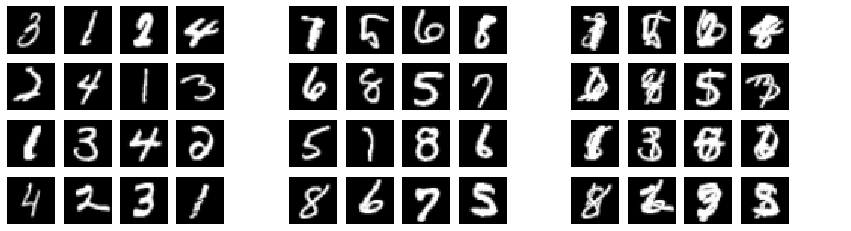

DRNets Separated Image


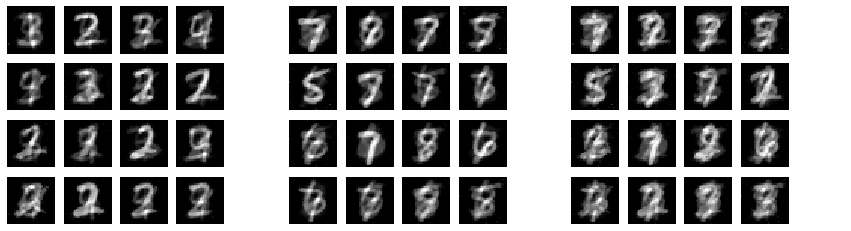

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
1,2,4,4, 7,6,7,5,
4,3,2,2, 5,7,7,6,
2,1,2,4, 6,7,8,6,
2,2,2,2, 7,7,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.000000, recon_loss = 0.299410
epoch = 1, Iteration 0: total_loss: 0.241754, loss_recon: 0.241754, entropy_cell: 1.006699, entropy_alldiff: 1.266207

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


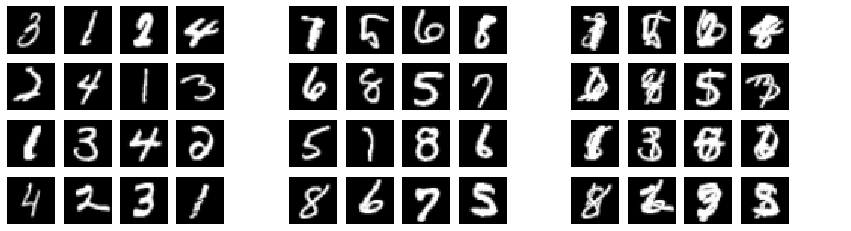

DRNets Separated Image


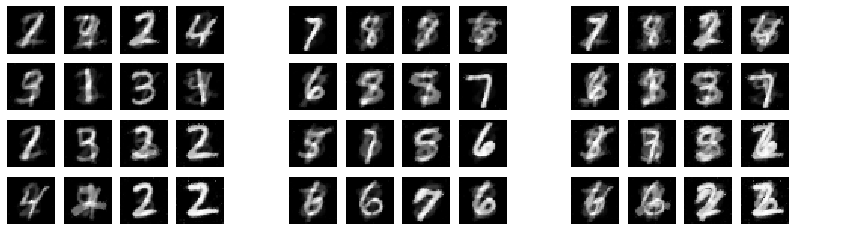

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
1,4,2,4, 7,8,7,5,
4,1,3,1, 6,7,5,7,
1,3,2,2, 5,7,5,6,
4,2,2,2, 6,6,7,6,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.250000, recon_loss = 0.241754
epoch = 2, Iteration 0: total_loss: 0.224559, loss_recon: 0.224559, entropy_cell: 0.757683, entropy_alldiff: 1.255835

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


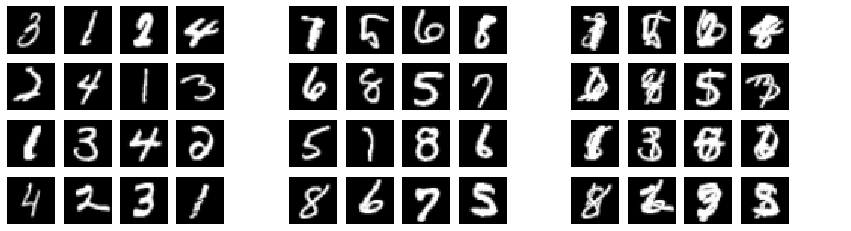

DRNets Separated Image


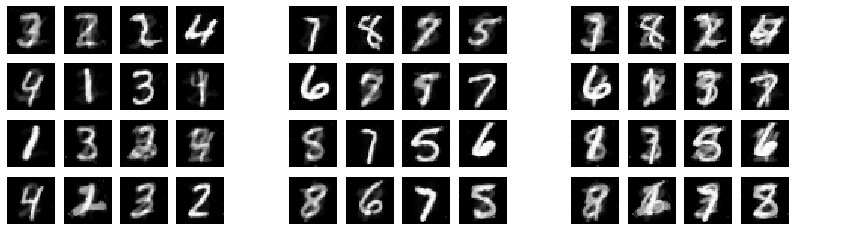

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,8,7,5,
4,1,3,1, 6,7,5,7,
1,3,2,4, 5,7,5,6,
4,2,3,2, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.375000, recon_loss = 0.224559
epoch = 3, Iteration 0: total_loss: 0.211045, loss_recon: 0.211045, entropy_cell: 0.655848, entropy_alldiff: 1.245924

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


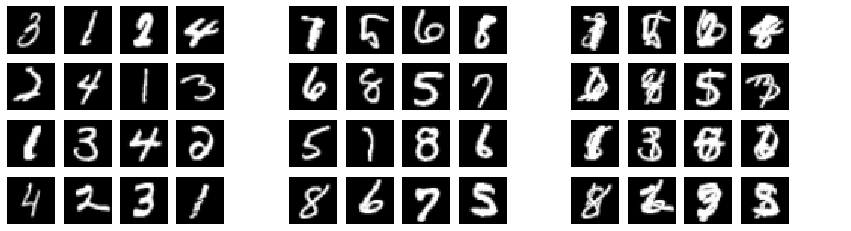

DRNets Separated Image


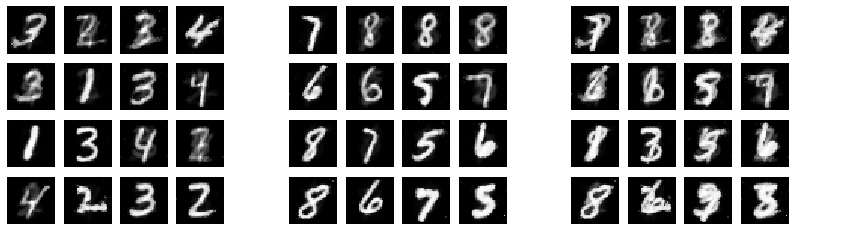

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,3,4, 7,8,8,8,
3,1,3,4, 6,6,5,7,
1,3,4,2, 8,7,5,6,
4,2,3,2, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.437500, recon_loss = 0.211045
epoch = 4, Iteration 0: total_loss: 0.216799, loss_recon: 0.216799, entropy_cell: 0.597755, entropy_alldiff: 1.221128

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


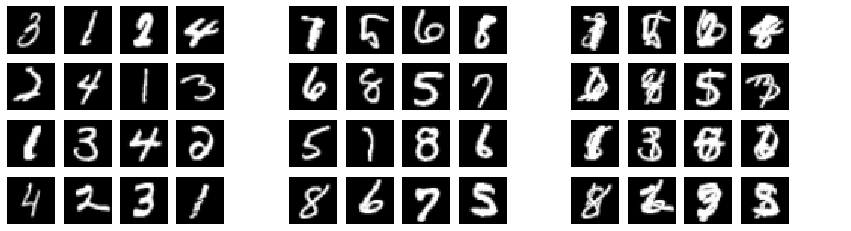

DRNets Separated Image


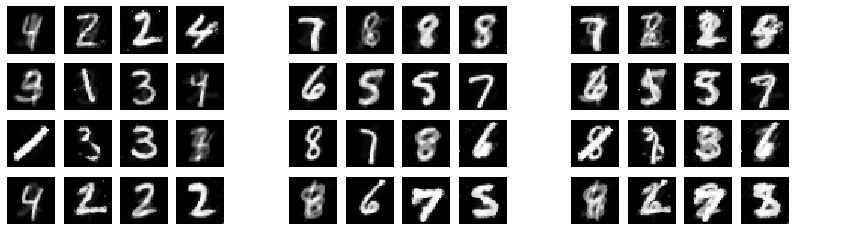

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
4,2,2,4, 7,8,8,5,
3,1,3,4, 6,5,5,7,
1,3,3,1, 8,7,8,6,
4,2,2,2, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.187500, recon_loss = 0.216799
epoch = 5, Iteration 0: total_loss: 0.208793, loss_recon: 0.208793, entropy_cell: 0.591855, entropy_alldiff: 1.179860

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


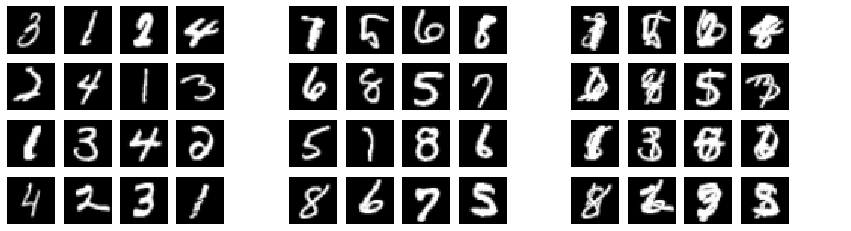

DRNets Separated Image


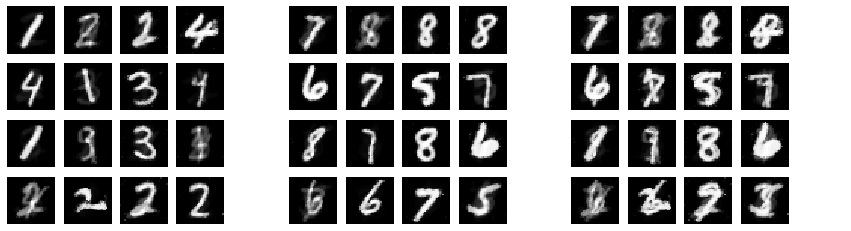

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
1,2,2,4, 7,8,8,8,
4,1,3,4, 6,7,5,7,
1,3,3,4, 8,7,8,6,
2,2,2,2, 6,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.187500, recon_loss = 0.208793
epoch = 6, Iteration 0: total_loss: 0.208462, loss_recon: 0.208462, entropy_cell: 0.612185, entropy_alldiff: 1.185733

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


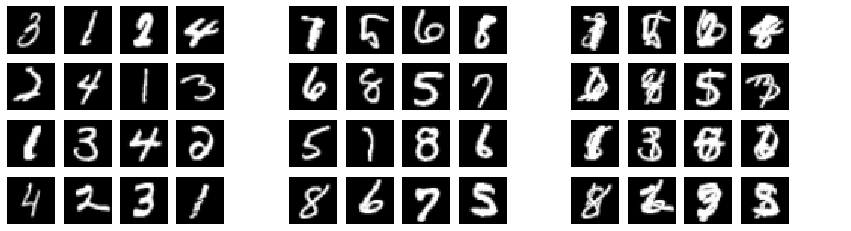

DRNets Separated Image


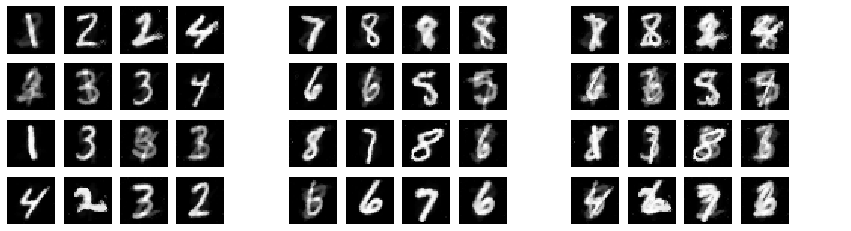

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
1,2,2,4, 7,8,8,8,
2,3,3,4, 6,6,5,5,
1,3,3,3, 8,7,8,6,
4,2,3,2, 6,6,7,6,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.312500, recon_loss = 0.208462
epoch = 7, Iteration 0: total_loss: 0.182569, loss_recon: 0.182569, entropy_cell: 0.506848, entropy_alldiff: 1.179372

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


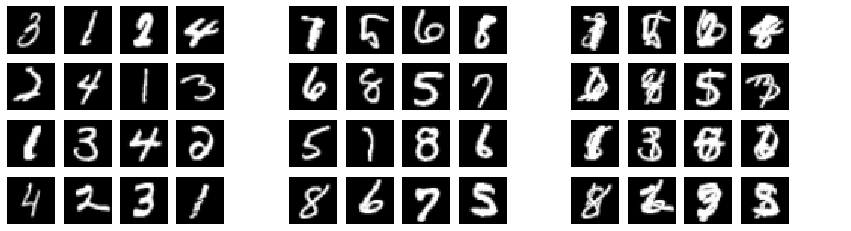

DRNets Separated Image


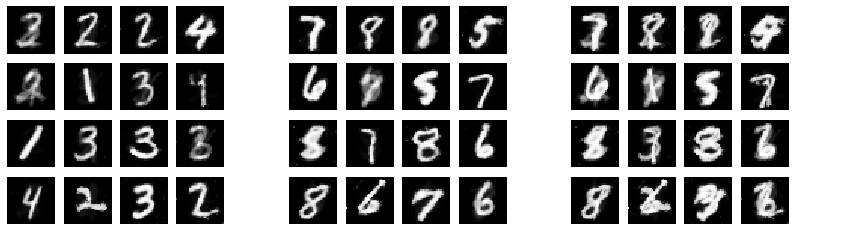

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,8,8,5,
2,1,3,4, 6,7,5,7,
1,3,3,2, 8,7,8,6,
4,2,3,2, 8,6,7,6,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.437500, recon_loss = 0.182569
epoch = 8, Iteration 0: total_loss: 0.188453, loss_recon: 0.188453, entropy_cell: 0.496099, entropy_alldiff: 1.201338

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


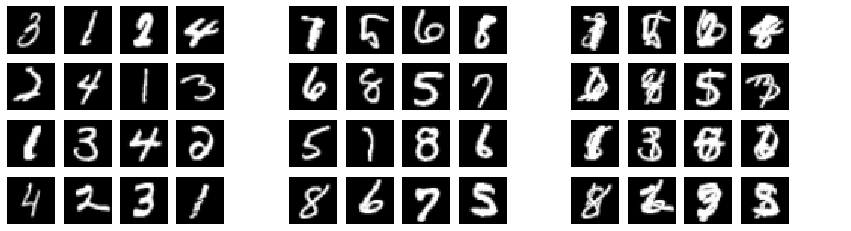

DRNets Separated Image


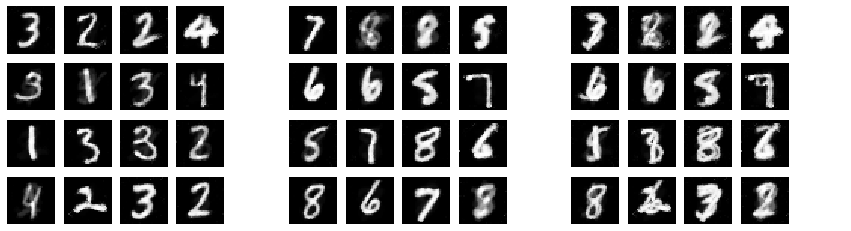

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,8,8,5,
3,1,3,4, 6,6,5,7,
1,3,3,2, 5,7,8,6,
4,2,3,2, 8,6,7,8,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.437500, recon_loss = 0.188453
epoch = 9, Iteration 0: total_loss: 0.196766, loss_recon: 0.196766, entropy_cell: 0.464346, entropy_alldiff: 1.227994

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


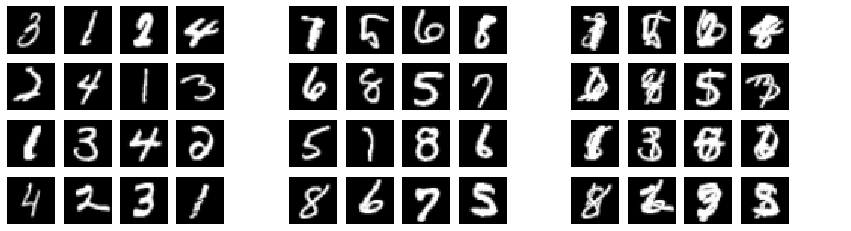

DRNets Separated Image


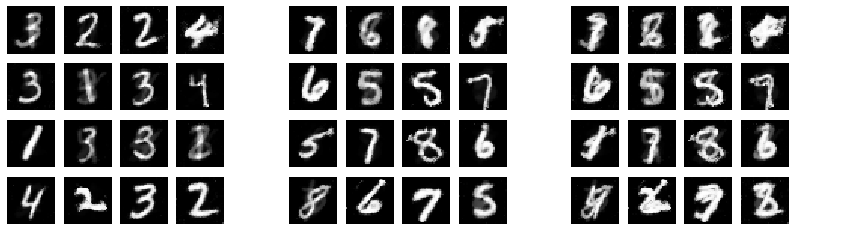

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,6,8,5,
3,1,3,4, 6,5,5,7,
1,3,3,1, 5,7,8,6,
4,2,3,2, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.375000, recon_loss = 0.196766
epoch = 10, Iteration 0: total_loss: -1.061330, loss_recon: 0.186016, entropy_cell: 0.481187, entropy_alldiff: 1.252158

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


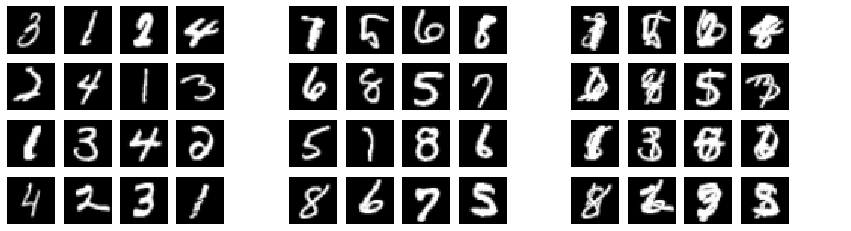

DRNets Separated Image


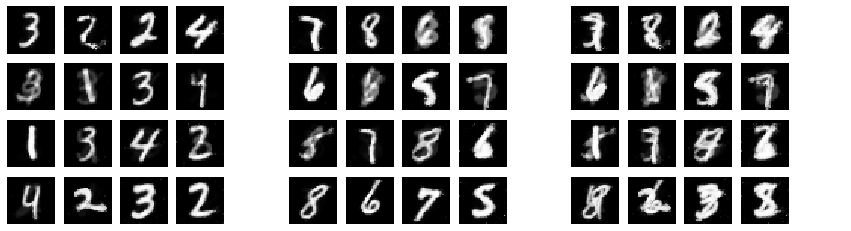

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,8,6,5,
3,1,3,4, 6,6,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,2, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.562500, recon_loss = 0.186016
epoch = 11, Iteration 0: total_loss: -1.111250, loss_recon: 0.197713, entropy_cell: 0.528615, entropy_alldiff: 1.314250

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


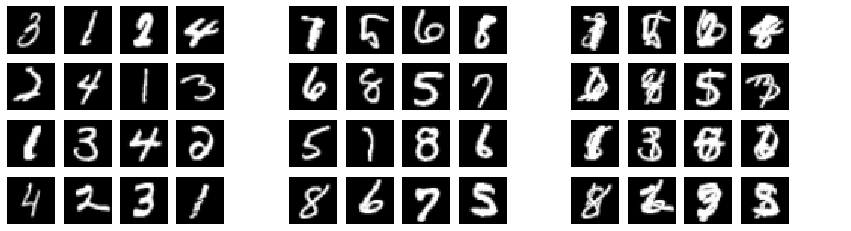

DRNets Separated Image


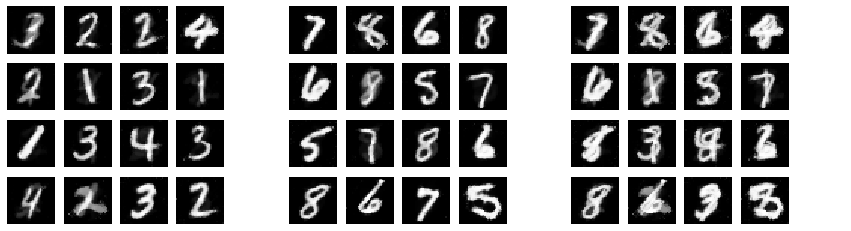

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,8,6,8,
2,1,3,1, 6,8,5,7,
1,3,4,3, 5,7,8,6,
4,2,3,2, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.625000, recon_loss = 0.197713
epoch = 12, Iteration 0: total_loss: -1.117427, loss_recon: 0.193619, entropy_cell: 0.655933, entropy_alldiff: 1.317606

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


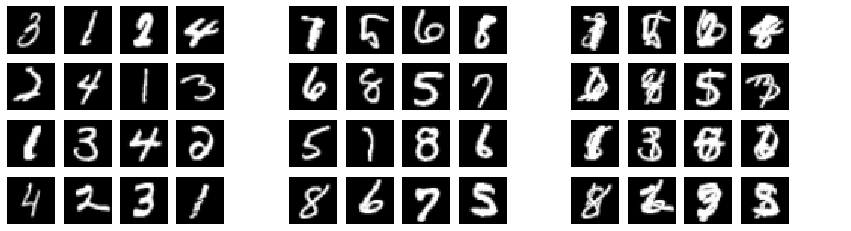

DRNets Separated Image


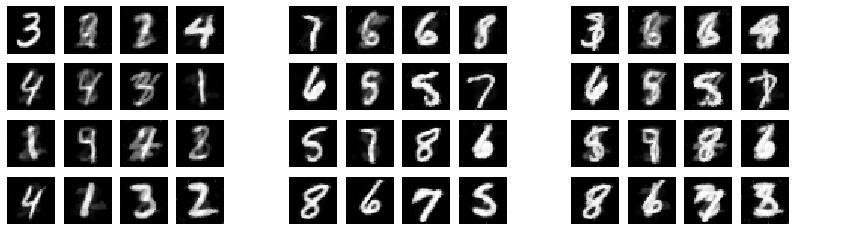

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,4,1,4, 7,6,6,8,
4,4,3,1, 6,5,5,7,
1,4,4,2, 5,7,8,6,
4,1,3,2, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.437500, recon_loss = 0.193619
epoch = 13, Iteration 0: total_loss: -1.149572, loss_recon: 0.187089, entropy_cell: 0.657944, entropy_alldiff: 1.343241

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


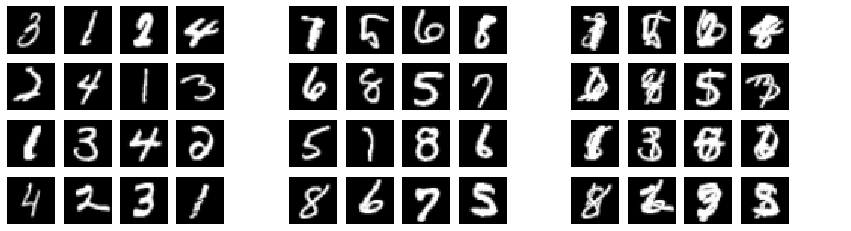

DRNets Separated Image


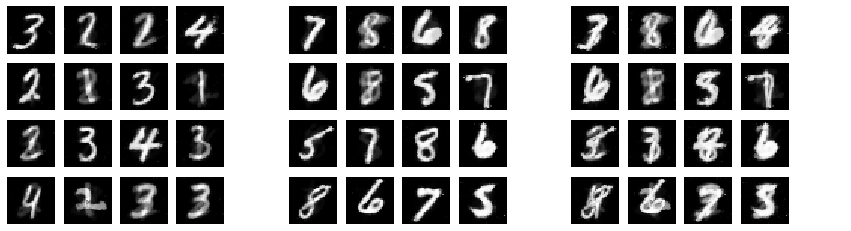

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,1,4, 7,8,6,8,
2,1,3,1, 6,8,5,7,
2,3,4,3, 5,7,8,6,
4,2,3,3, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.500000, recon_loss = 0.187089
epoch = 14, Iteration 0: total_loss: -1.134218, loss_recon: 0.188343, entropy_cell: 0.612994, entropy_alldiff: 1.328691

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


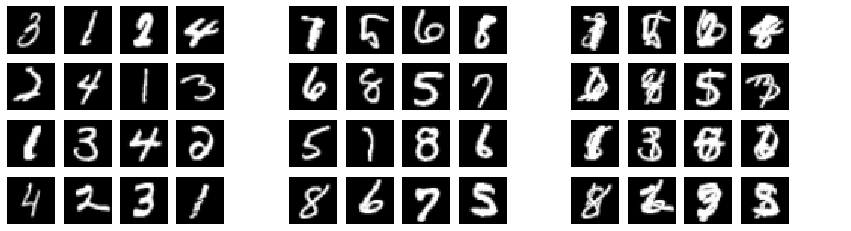

DRNets Separated Image


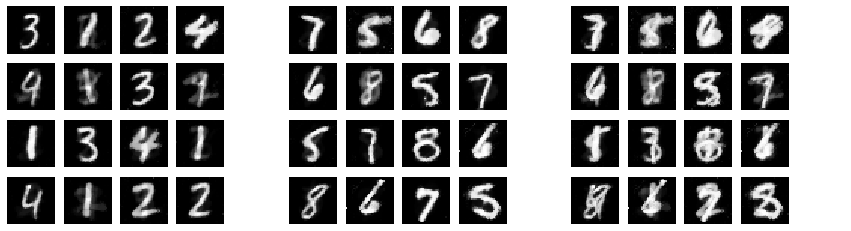

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
4,1,3,4, 6,8,5,7,
1,3,4,1, 5,7,8,6,
4,1,2,2, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.500000, recon_loss = 0.188343
epoch = 15, Iteration 0: total_loss: -1.178106, loss_recon: 0.175608, entropy_cell: 0.708612, entropy_alldiff: 1.360800

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


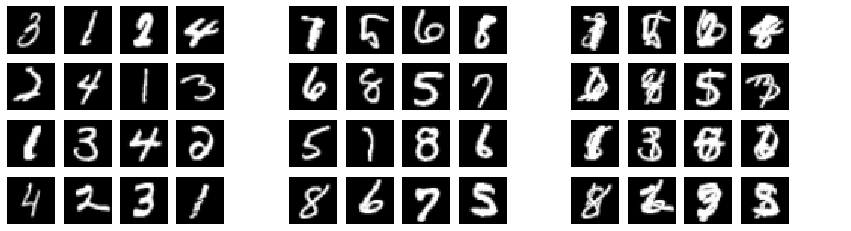

DRNets Separated Image


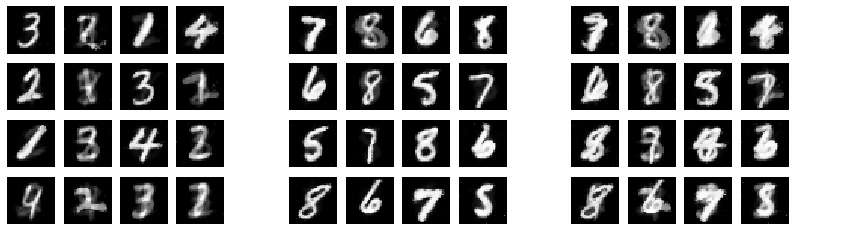

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,1,4, 7,8,6,8,
2,1,3,2, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.687500, recon_loss = 0.175608
epoch = 16, Iteration 0: total_loss: -1.158966, loss_recon: 0.178597, entropy_cell: 0.686932, entropy_alldiff: 1.344432

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


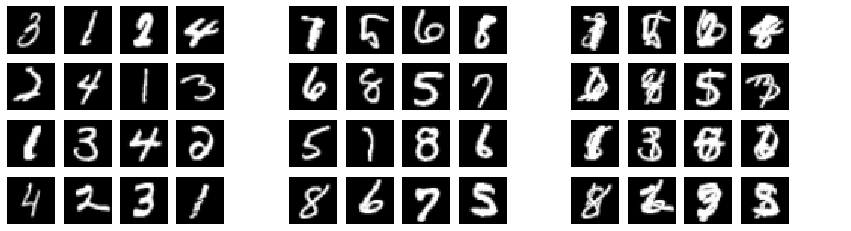

DRNets Separated Image


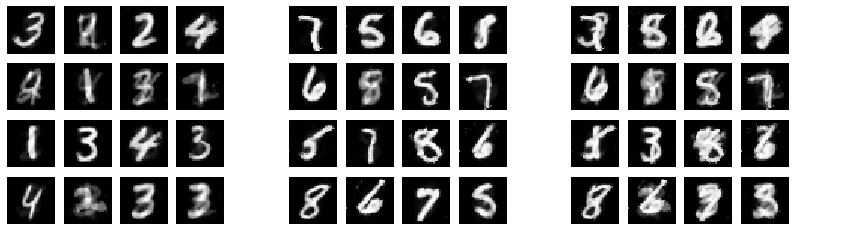

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,4,2,4, 7,5,6,8,
4,1,3,1, 6,5,5,7,
1,3,4,3, 5,7,8,6,
4,2,3,3, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.562500, recon_loss = 0.178597
epoch = 17, Iteration 0: total_loss: -1.174125, loss_recon: 0.175229, entropy_cell: 0.653396, entropy_alldiff: 1.355888

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


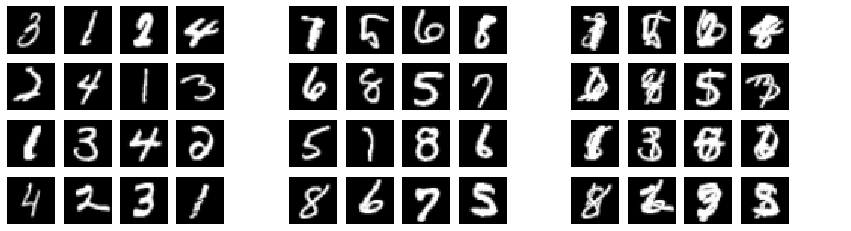

DRNets Separated Image


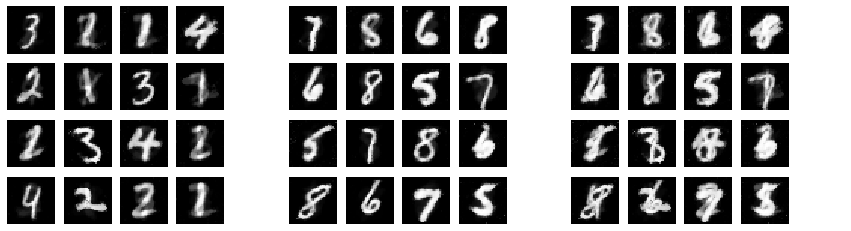

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,1,4, 7,5,6,8,
2,1,3,1, 6,8,5,7,
2,3,4,2, 5,7,8,6,
4,2,2,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.625000, recon_loss = 0.175229
epoch = 18, Iteration 0: total_loss: -1.178392, loss_recon: 0.170285, entropy_cell: 0.647083, entropy_alldiff: 1.355148

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


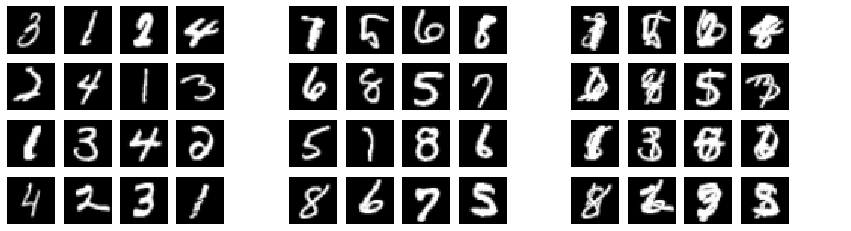

DRNets Separated Image


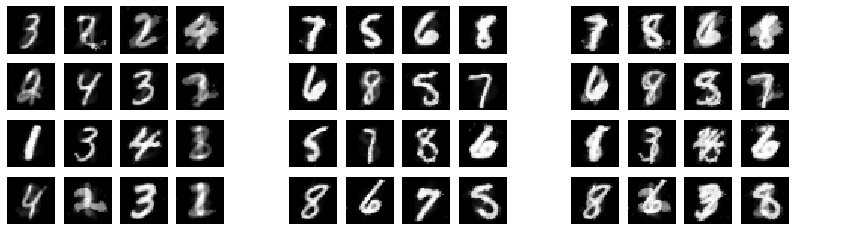

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,5,6,8,
2,4,3,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.875000, recon_loss = 0.170285
epoch = 19, Iteration 0: total_loss: -1.179167, loss_recon: 0.172989, entropy_cell: 0.586055, entropy_alldiff: 1.358016

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


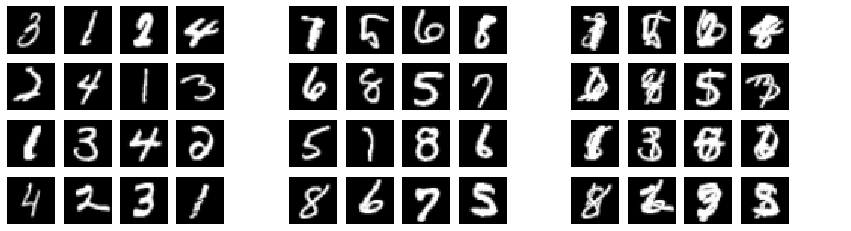

DRNets Separated Image


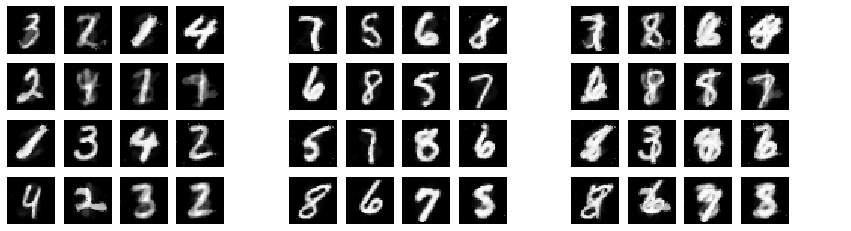

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,1,4, 7,5,6,8,
2,4,1,1, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,2, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.750000, recon_loss = 0.172989
epoch = 20, Iteration 0: total_loss: -1.187544, loss_recon: 0.166009, entropy_cell: 0.610118, entropy_alldiff: 1.359654

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


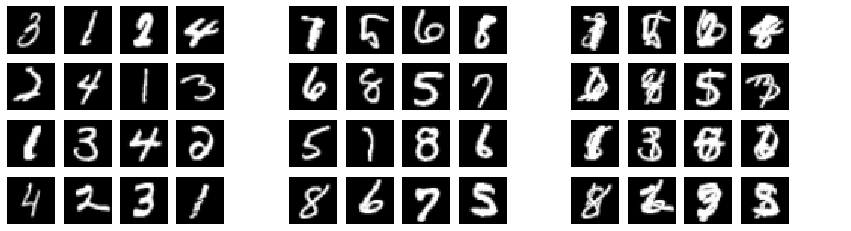

DRNets Separated Image


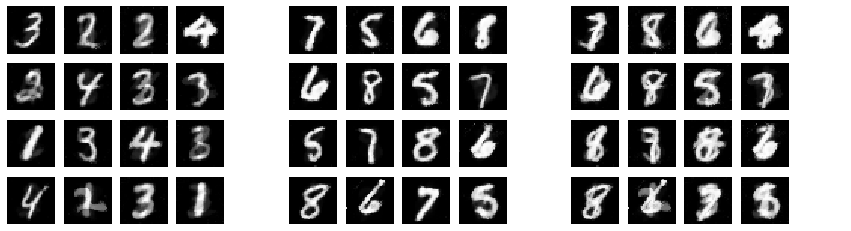

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,5,6,8,
2,4,3,3, 6,8,5,7,
1,3,4,3, 5,7,8,6,
4,1,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.750000, recon_loss = 0.166009
epoch = 21, Iteration 0: total_loss: -1.180688, loss_recon: 0.164461, entropy_cell: 0.584358, entropy_alldiff: 1.350992

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


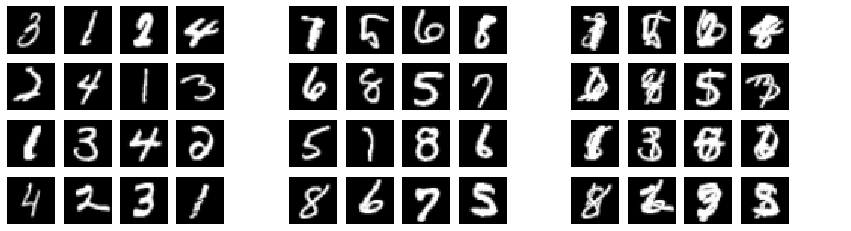

DRNets Separated Image


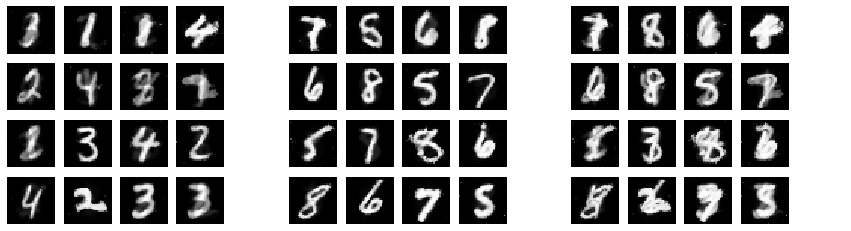

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
1,1,1,4, 7,5,6,8,
2,4,2,2, 6,8,5,7,
2,3,4,2, 5,7,8,6,
4,2,3,3, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.625000, recon_loss = 0.164461
epoch = 22, Iteration 0: total_loss: -1.197264, loss_recon: 0.159809, entropy_cell: 0.522609, entropy_alldiff: 1.362299

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


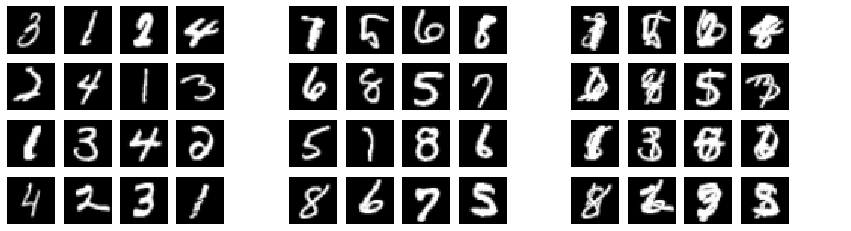

DRNets Separated Image


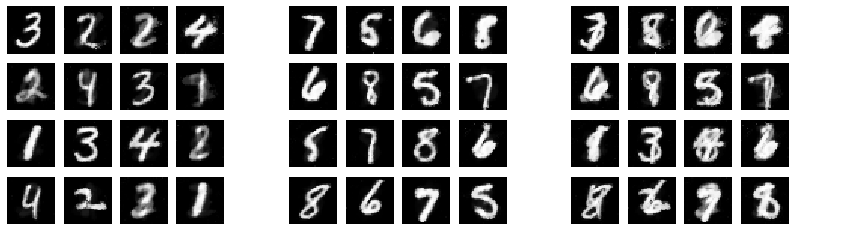

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,5,6,8,
2,4,3,1, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.812500, recon_loss = 0.159809
epoch = 23, Iteration 0: total_loss: -1.184406, loss_recon: 0.170238, entropy_cell: 0.516948, entropy_alldiff: 1.359814

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


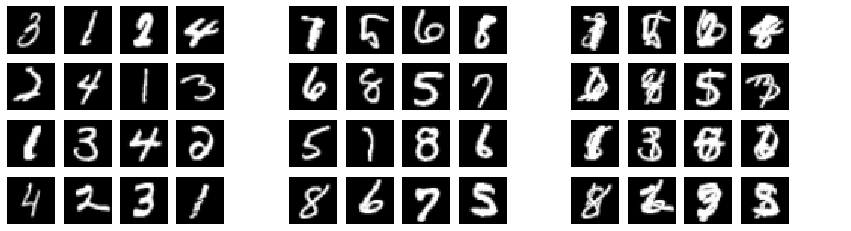

DRNets Separated Image


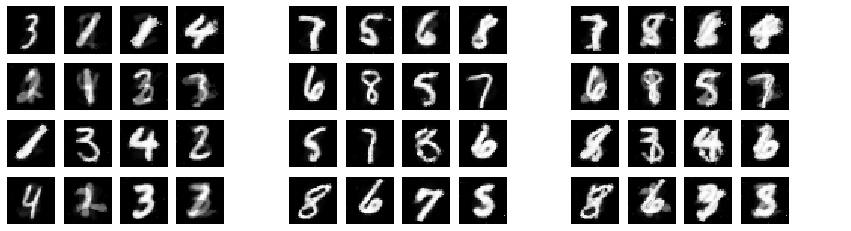

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,1,4, 7,5,6,8,
2,1,3,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,1,3,3, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.687500, recon_loss = 0.170238
epoch = 24, Iteration 0: total_loss: -1.197172, loss_recon: 0.162646, entropy_cell: 0.484880, entropy_alldiff: 1.364667

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


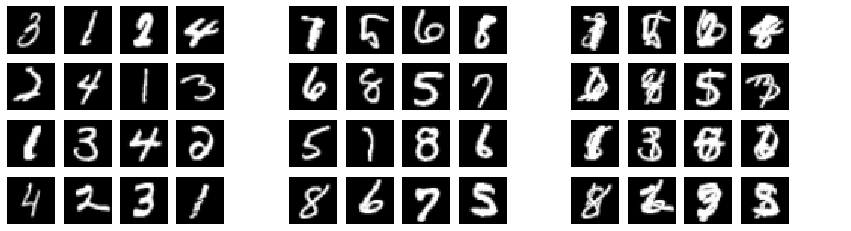

DRNets Separated Image


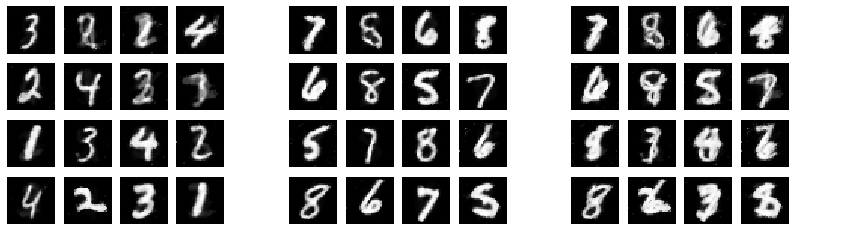

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,1,4, 7,5,6,8,
2,4,2,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.812500, recon_loss = 0.162646
epoch = 25, Iteration 0: total_loss: -1.187483, loss_recon: 0.163599, entropy_cell: 0.481425, entropy_alldiff: 1.355896

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


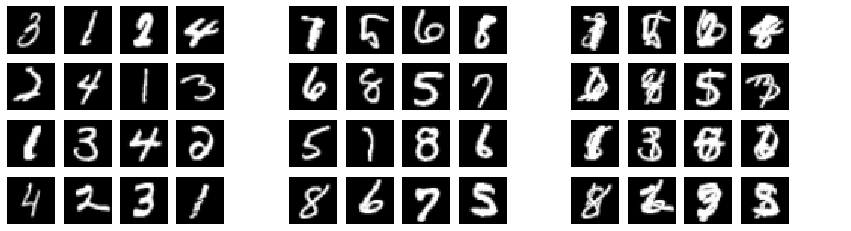

DRNets Separated Image


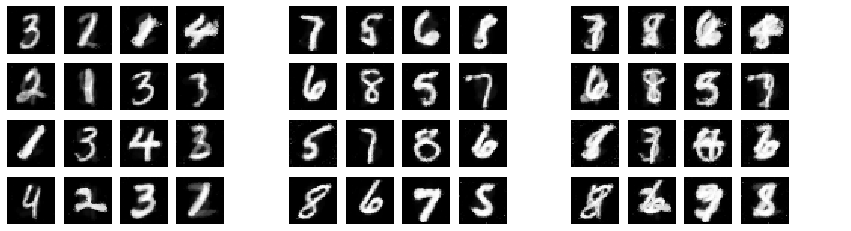

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,1,4, 7,5,6,8,
2,1,3,3, 6,8,5,7,
1,3,4,3, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.750000, recon_loss = 0.163599
epoch = 26, Iteration 0: total_loss: -1.189918, loss_recon: 0.162217, entropy_cell: 0.503223, entropy_alldiff: 1.357168

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


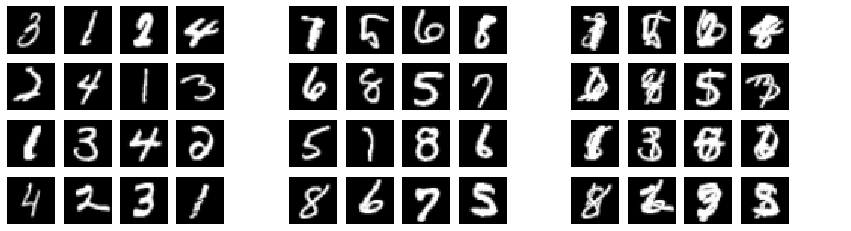

DRNets Separated Image


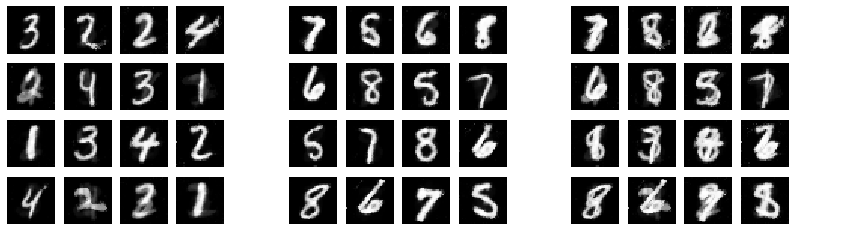

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,5,6,8,
2,4,3,1, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.812500, recon_loss = 0.162217
epoch = 27, Iteration 0: total_loss: -1.200087, loss_recon: 0.162782, entropy_cell: 0.516846, entropy_alldiff: 1.368038

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


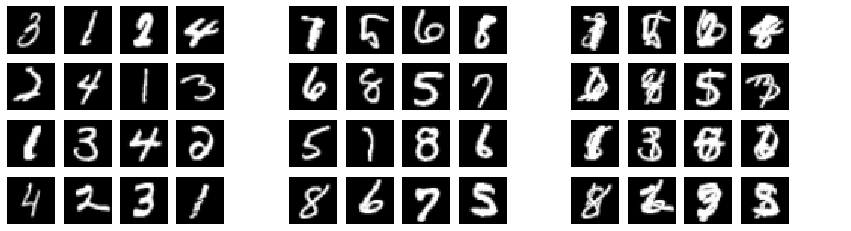

DRNets Separated Image


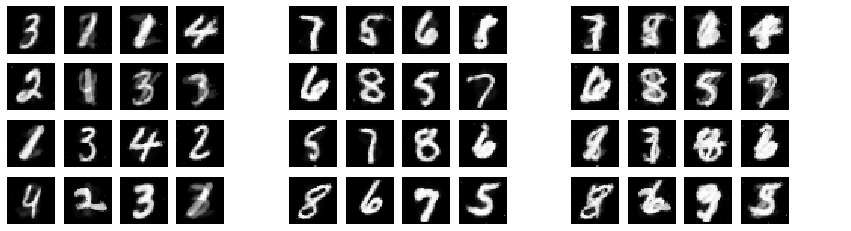

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,1,4, 7,5,6,8,
2,1,3,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.812500, recon_loss = 0.162782
epoch = 28, Iteration 0: total_loss: -1.198353, loss_recon: 0.158532, entropy_cell: 0.502091, entropy_alldiff: 1.361906

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


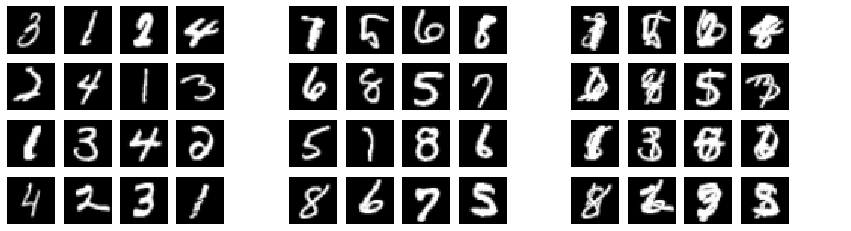

DRNets Separated Image


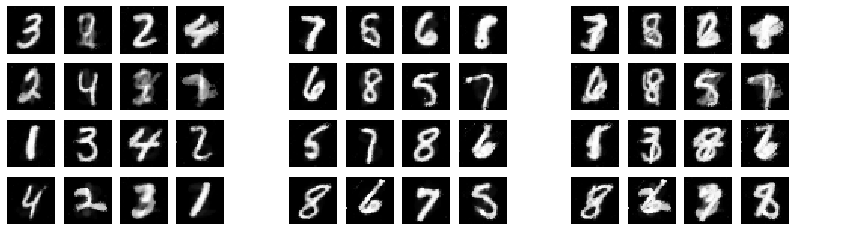

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,4,2,4, 7,5,6,8,
2,4,4,2, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.812500, recon_loss = 0.158532
epoch = 29, Iteration 0: total_loss: -1.213518, loss_recon: 0.154686, entropy_cell: 0.498135, entropy_alldiff: 1.373185

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


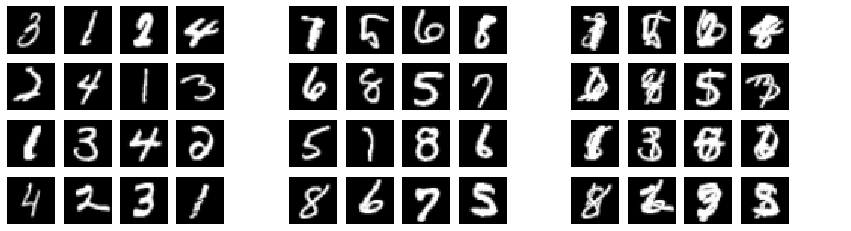

DRNets Separated Image


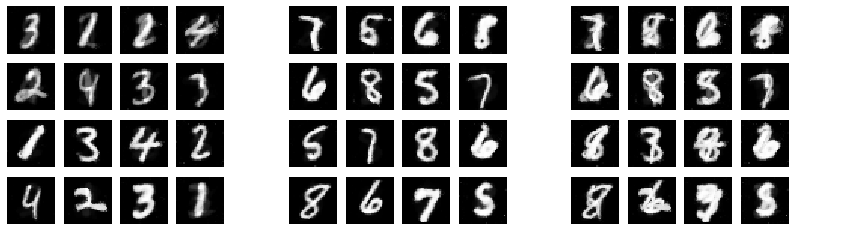

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,1,4, 7,5,6,8,
2,4,3,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.875000, recon_loss = 0.154686
epoch = 30, Iteration 0: total_loss: -1.205944, loss_recon: 0.156560, entropy_cell: 0.422631, entropy_alldiff: 1.366729

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


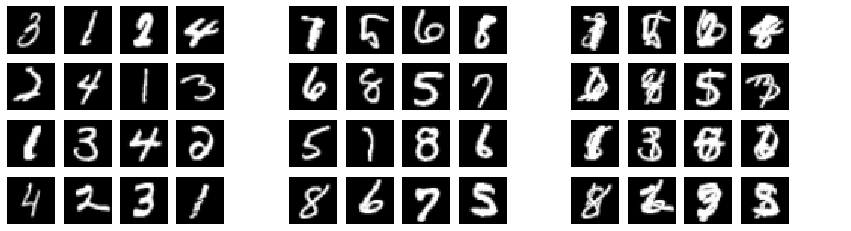

DRNets Separated Image


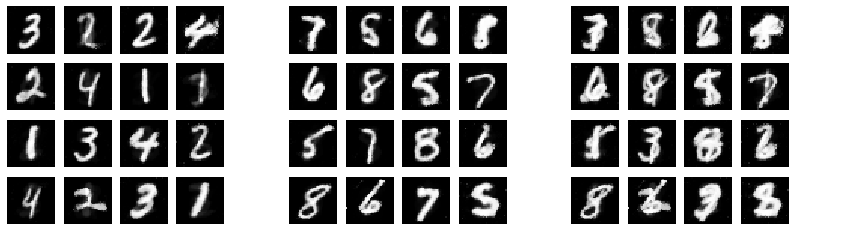

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,2,2,4, 7,5,6,8,
2,4,1,1, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.875000, recon_loss = 0.156560
epoch = 31, Iteration 0: total_loss: -1.225845, loss_recon: 0.152762, entropy_cell: 0.432675, entropy_alldiff: 1.382934

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


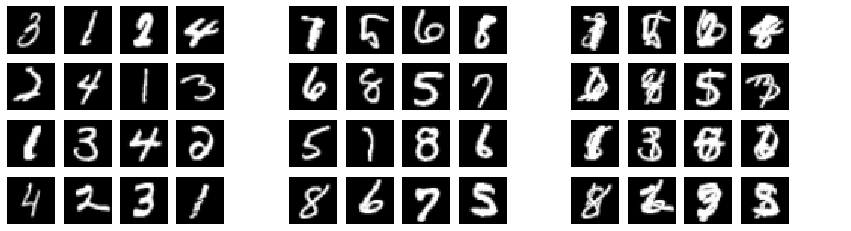

DRNets Separated Image


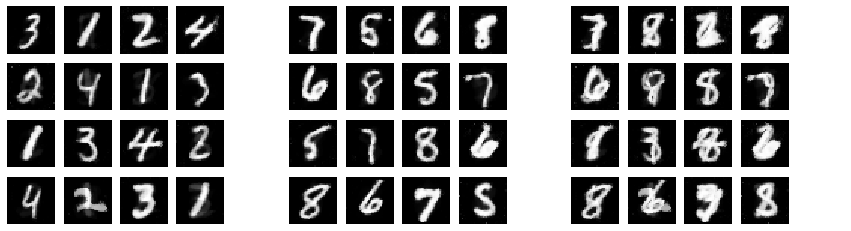

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.152762
epoch = 32, Iteration 0: total_loss: -1.221967, loss_recon: 0.155460, entropy_cell: 0.378673, entropy_alldiff: 1.381213

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


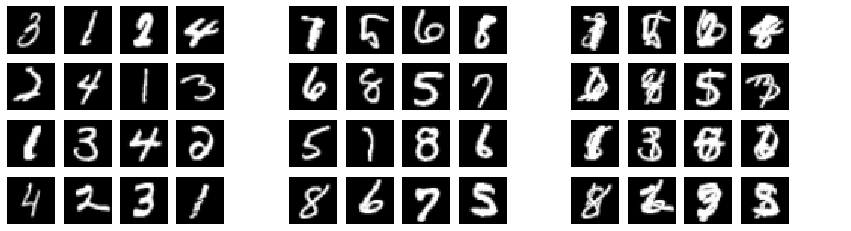

DRNets Separated Image


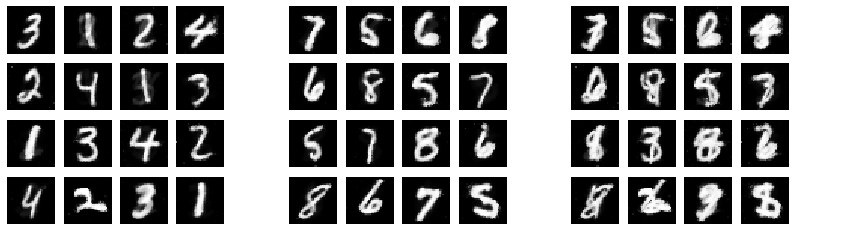

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.155460
epoch = 33, Iteration 0: total_loss: -1.224777, loss_recon: 0.154451, entropy_cell: 0.331681, entropy_alldiff: 1.382545

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


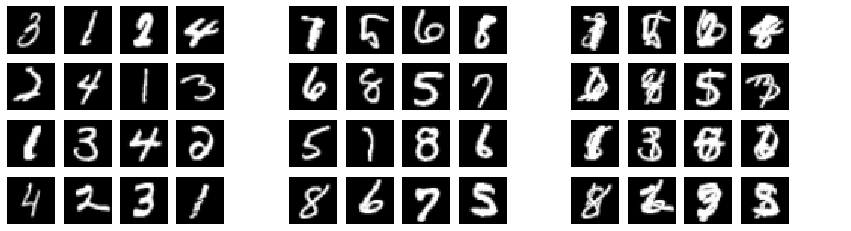

DRNets Separated Image


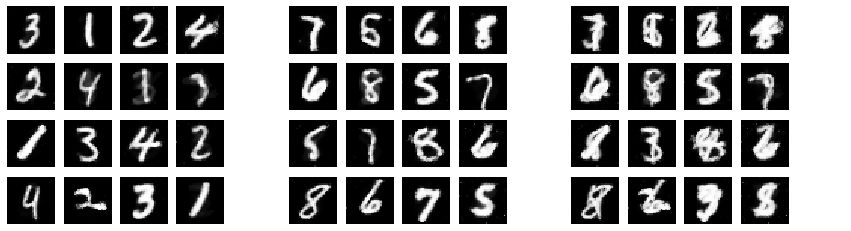

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.154451
epoch = 34, Iteration 0: total_loss: -1.225339, loss_recon: 0.148562, entropy_cell: 0.306942, entropy_alldiff: 1.376971

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


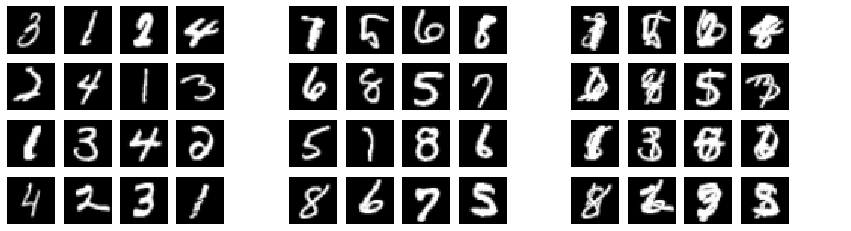

DRNets Separated Image


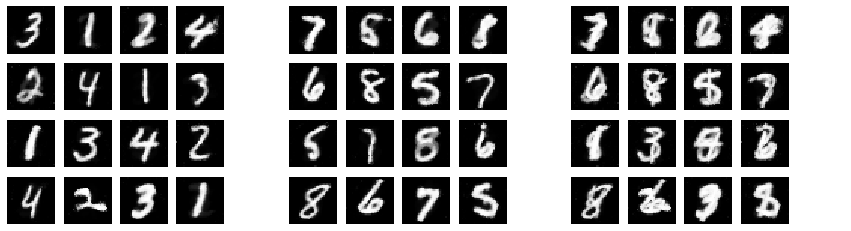

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.148562
epoch = 35, Iteration 0: total_loss: -1.228937, loss_recon: 0.153219, entropy_cell: 0.260027, entropy_alldiff: 1.384756

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


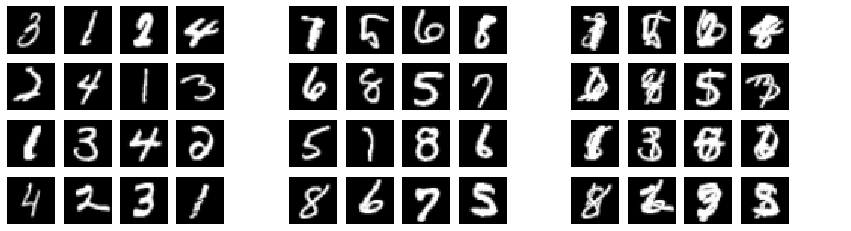

DRNets Separated Image


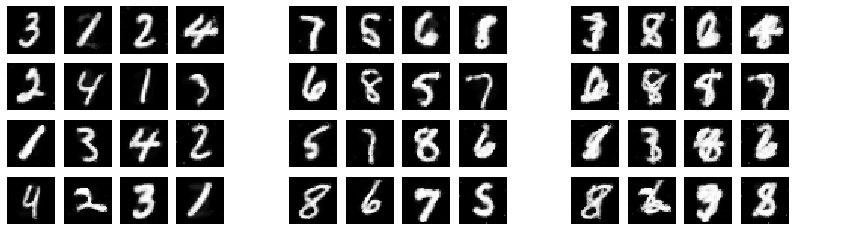

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.153219
epoch = 36, Iteration 0: total_loss: -1.228653, loss_recon: 0.152718, entropy_cell: 0.254841, entropy_alldiff: 1.383919

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


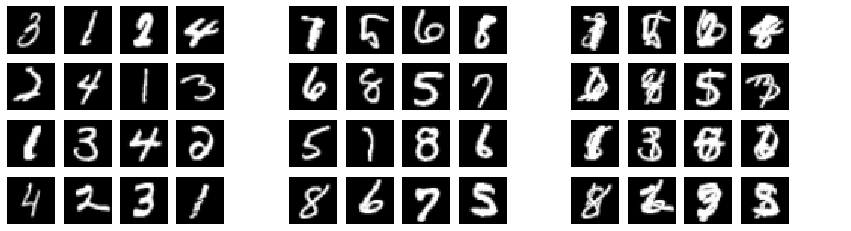

DRNets Separated Image


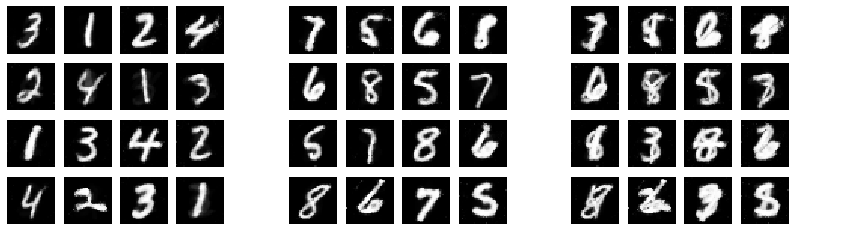

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.152718
epoch = 37, Iteration 0: total_loss: -1.234166, loss_recon: 0.147776, entropy_cell: 0.251493, entropy_alldiff: 1.384457

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


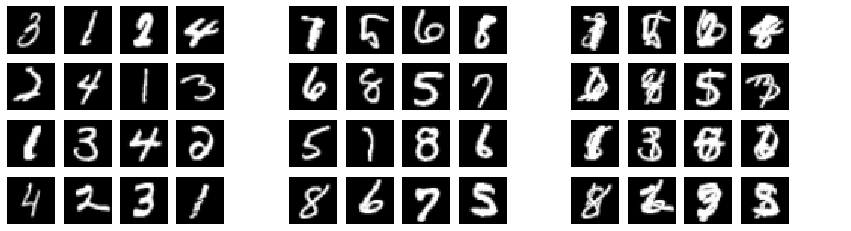

DRNets Separated Image


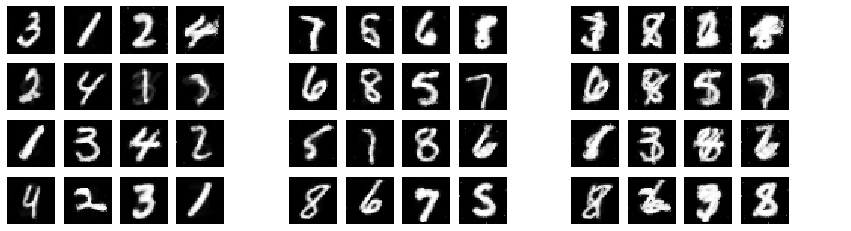

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.147776
epoch = 38, Iteration 0: total_loss: -1.223023, loss_recon: 0.152678, entropy_cell: 0.229024, entropy_alldiff: 1.377992

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


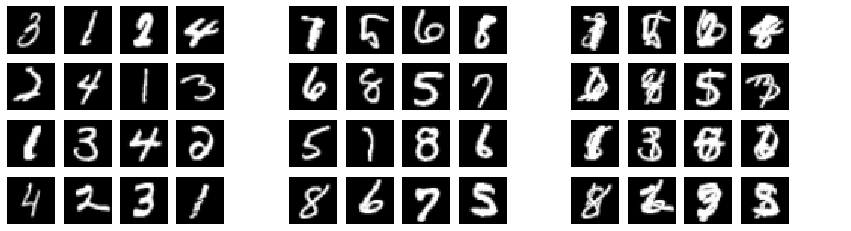

DRNets Separated Image


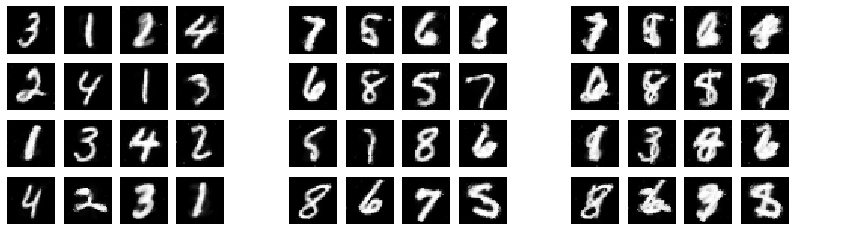

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,1,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.937500, recon_loss = 0.152678
epoch = 39, Iteration 0: total_loss: -1.238974, loss_recon: 0.144199, entropy_cell: 0.216954, entropy_alldiff: 1.385342

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


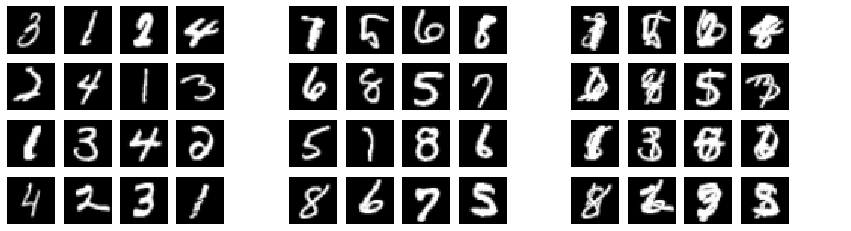

DRNets Separated Image


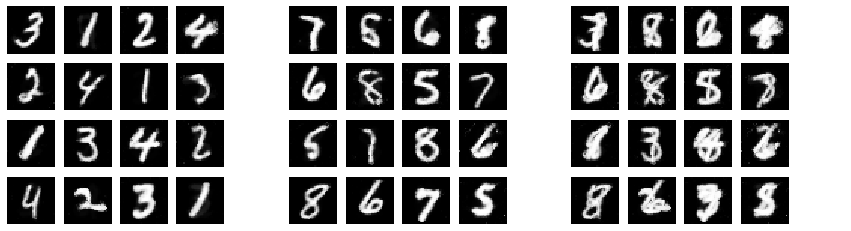

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.144199
epoch = 40, Iteration 0: total_loss: -1.226913, loss_recon: 0.149926, entropy_cell: 0.239068, entropy_alldiff: 1.379230

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


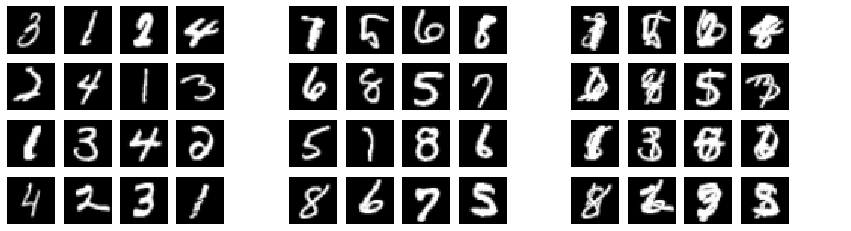

DRNets Separated Image


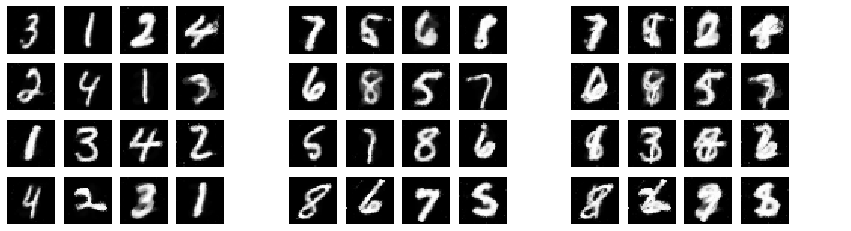

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.149926
epoch = 41, Iteration 0: total_loss: -1.238164, loss_recon: 0.145617, entropy_cell: 0.175267, entropy_alldiff: 1.385534

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


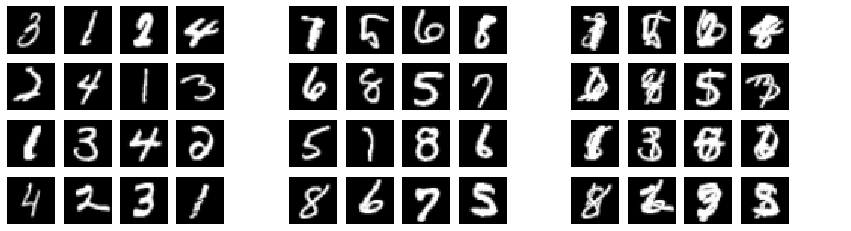

DRNets Separated Image


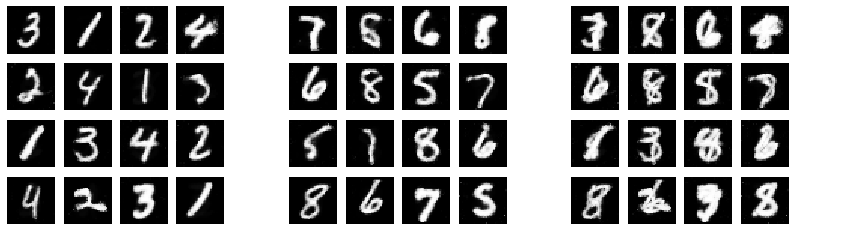

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.145617
epoch = 42, Iteration 0: total_loss: -1.239256, loss_recon: 0.144716, entropy_cell: 0.176646, entropy_alldiff: 1.385739

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


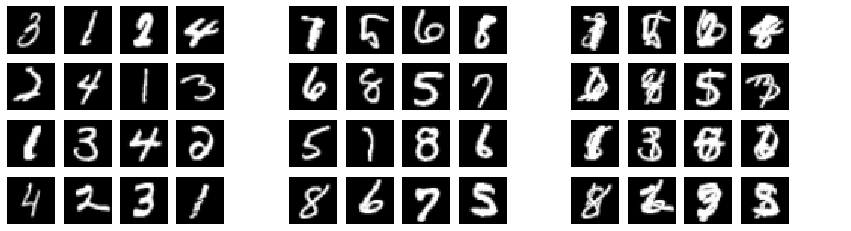

DRNets Separated Image


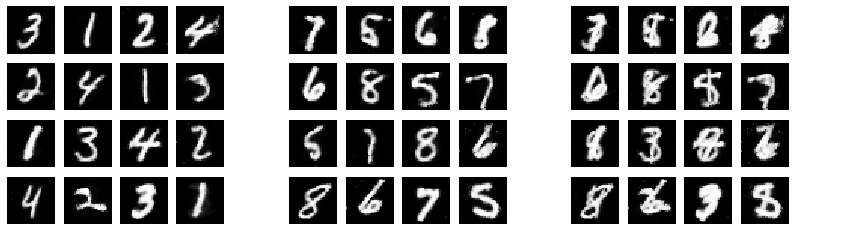

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.144716
epoch = 43, Iteration 0: total_loss: -1.238643, loss_recon: 0.144373, entropy_cell: 0.186433, entropy_alldiff: 1.384881

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


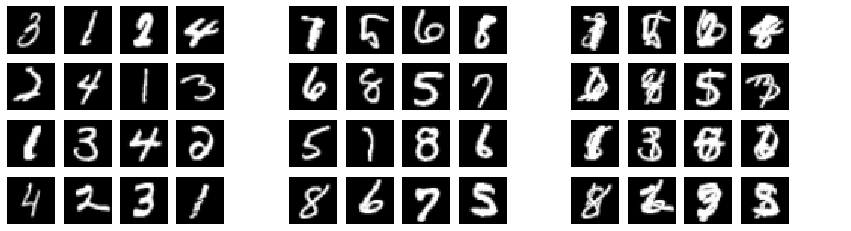

DRNets Separated Image


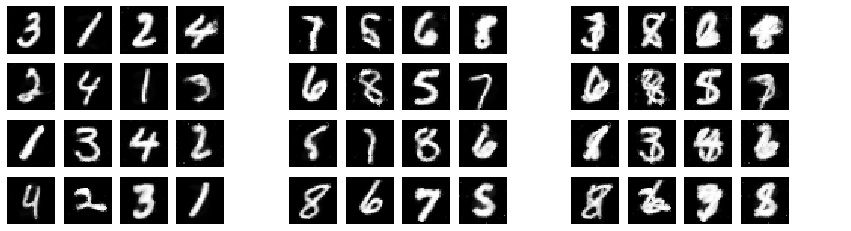

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.144373
epoch = 44, Iteration 0: total_loss: -1.243011, loss_recon: 0.141526, entropy_cell: 0.135734, entropy_alldiff: 1.385895

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


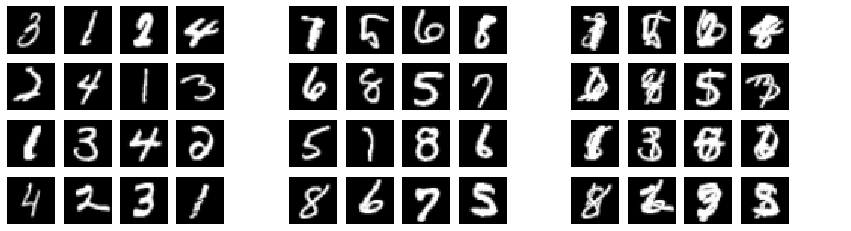

DRNets Separated Image


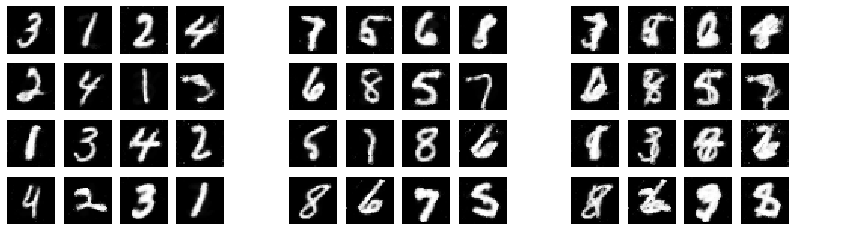

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.141526
epoch = 45, Iteration 0: total_loss: -1.240599, loss_recon: 0.142221, entropy_cell: 0.152444, entropy_alldiff: 1.384345

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


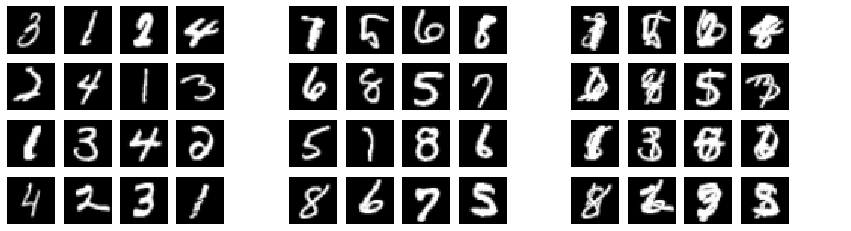

DRNets Separated Image


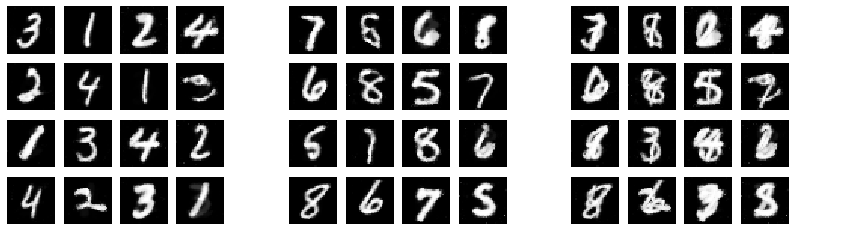

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.142221
epoch = 46, Iteration 0: total_loss: -1.243859, loss_recon: 0.141109, entropy_cell: 0.109559, entropy_alldiff: 1.386063

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


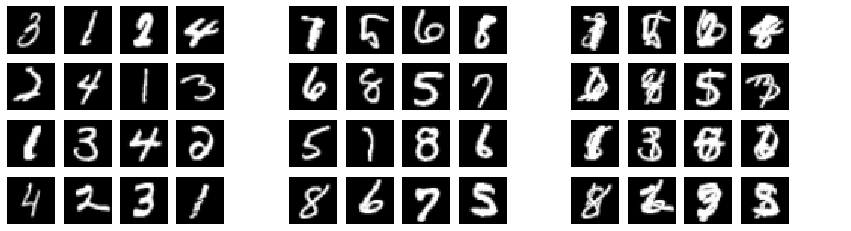

DRNets Separated Image


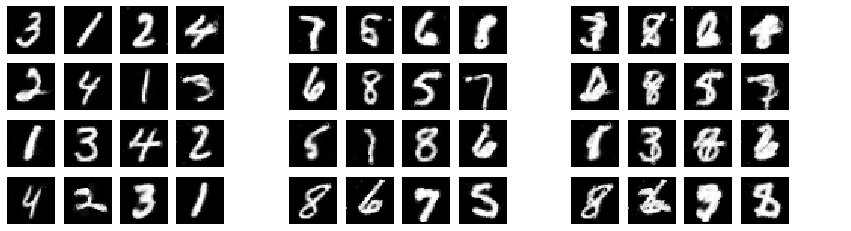

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.141109
epoch = 47, Iteration 0: total_loss: -1.244731, loss_recon: 0.140239, entropy_cell: 0.108268, entropy_alldiff: 1.386053

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


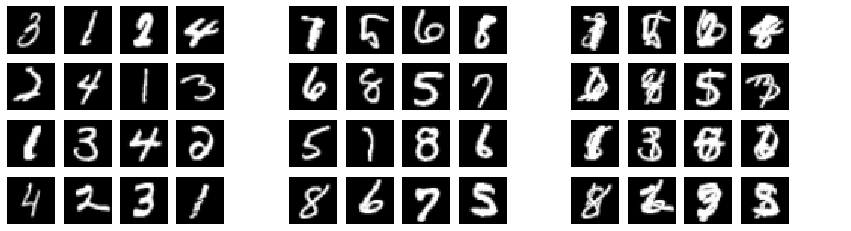

DRNets Separated Image


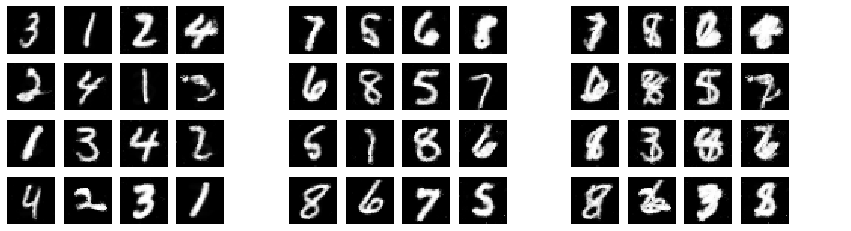

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.140239
epoch = 48, Iteration 0: total_loss: -1.246005, loss_recon: 0.136359, entropy_cell: 0.108110, entropy_alldiff: 1.383446

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


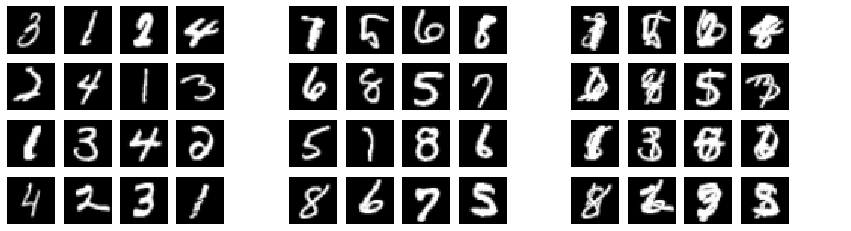

DRNets Separated Image


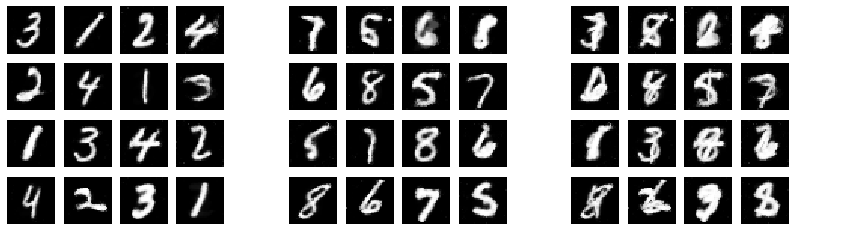

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.136359
epoch = 49, Iteration 0: total_loss: -1.245216, loss_recon: 0.140073, entropy_cell: 0.083356, entropy_alldiff: 1.386122

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


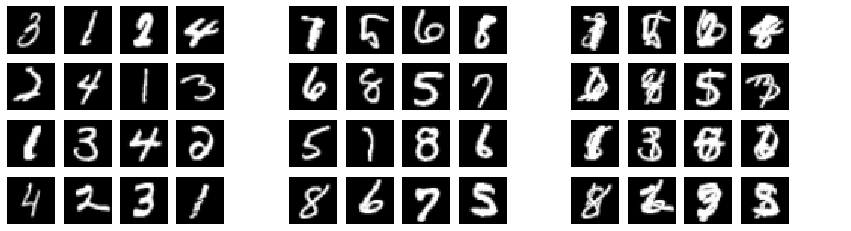

DRNets Separated Image


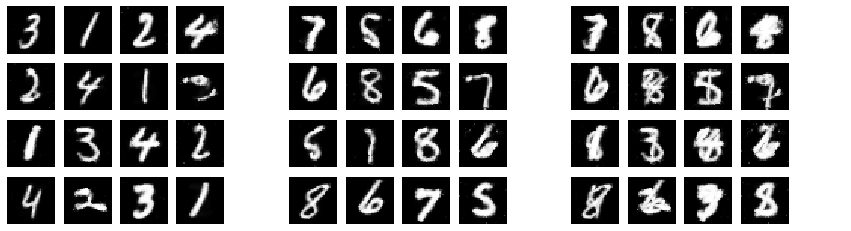

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.140073
epoch = 50, Iteration 0: total_loss: -1.233645, loss_recon: 0.138127, entropy_cell: 0.106325, entropy_alldiff: 1.372835

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


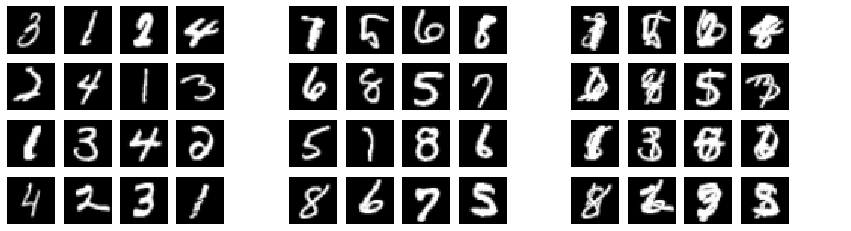

DRNets Separated Image


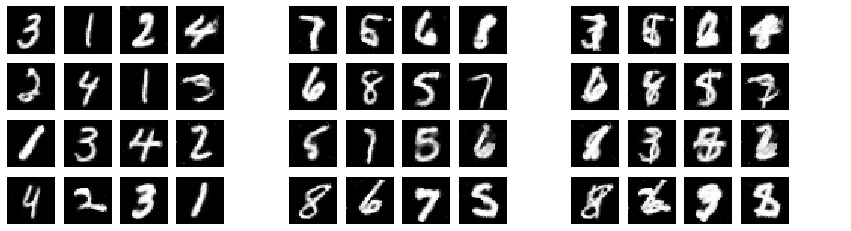

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,5,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.937500, recon_loss = 0.138127
epoch = 51, Iteration 0: total_loss: -1.244835, loss_recon: 0.136853, entropy_cell: 0.097076, entropy_alldiff: 1.382659

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


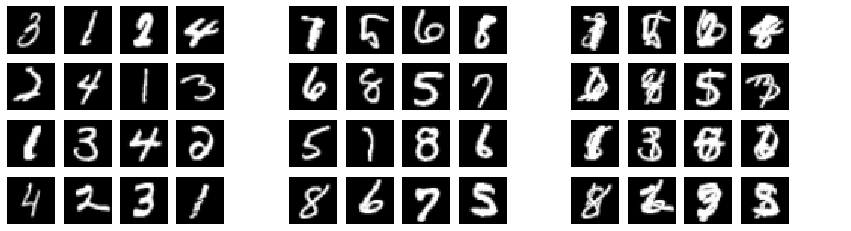

DRNets Separated Image


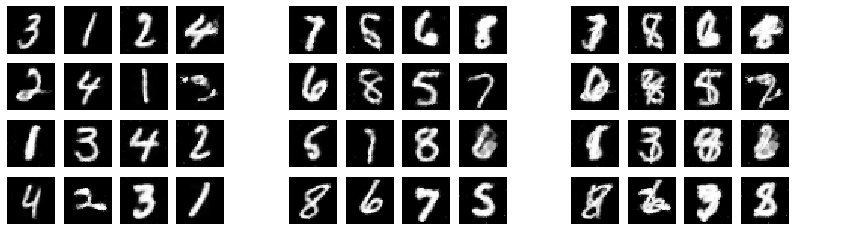

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.136853
epoch = 52, Iteration 0: total_loss: -1.246700, loss_recon: 0.138735, entropy_cell: 0.080624, entropy_alldiff: 1.386241

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


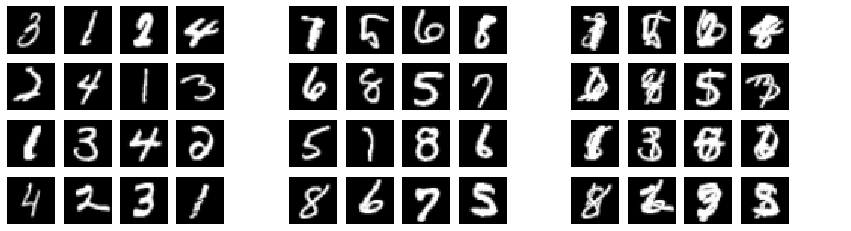

DRNets Separated Image


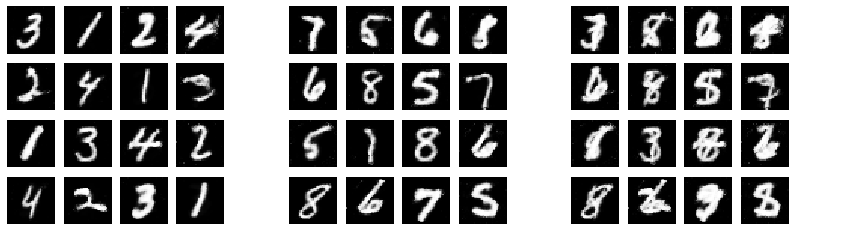

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.138735
epoch = 53, Iteration 0: total_loss: -1.244457, loss_recon: 0.132774, entropy_cell: 0.159188, entropy_alldiff: 1.378822

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


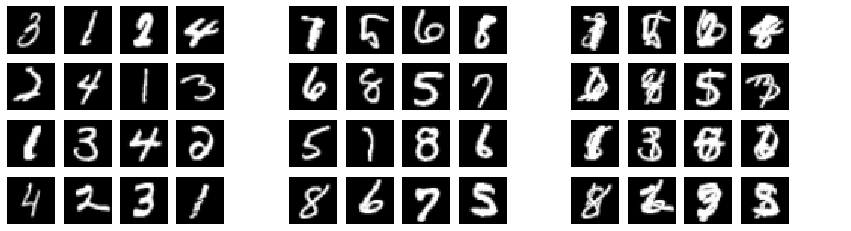

DRNets Separated Image


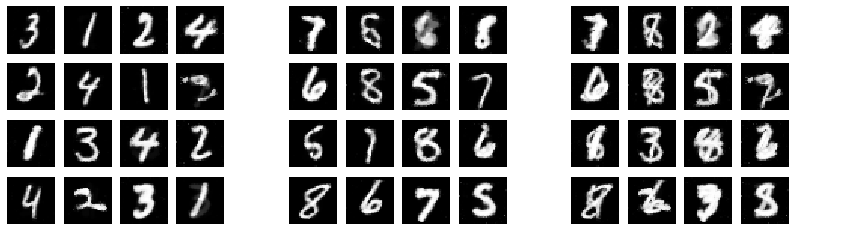

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.132774
epoch = 54, Iteration 0: total_loss: -1.251626, loss_recon: 0.133414, entropy_cell: 0.092947, entropy_alldiff: 1.385970

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


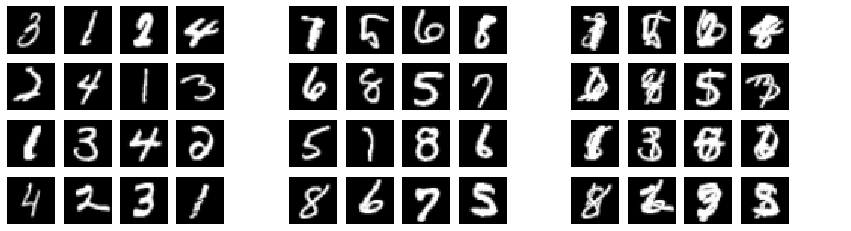

DRNets Separated Image


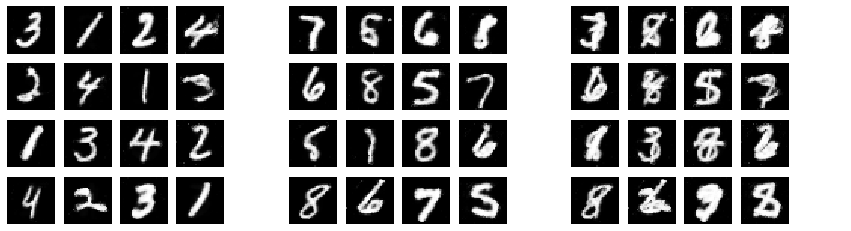

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.133414
epoch = 55, Iteration 0: total_loss: -1.244619, loss_recon: 0.139841, entropy_cell: 0.102141, entropy_alldiff: 1.385482

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


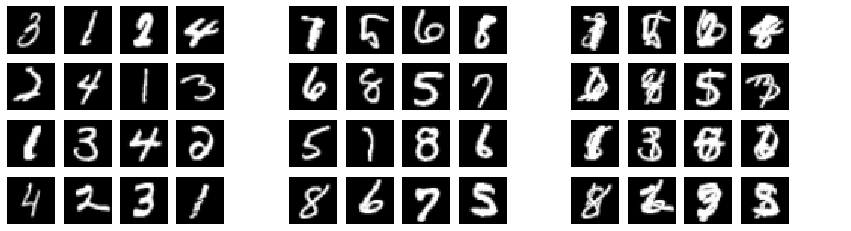

DRNets Separated Image


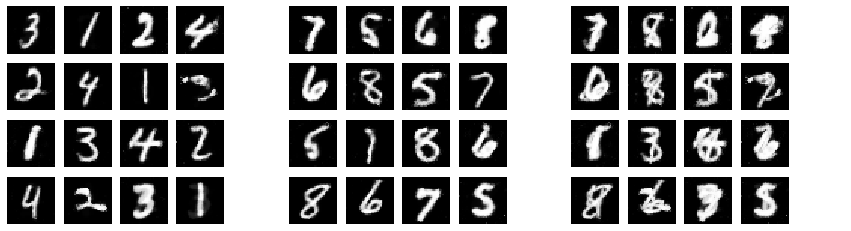

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.139841
epoch = 56, Iteration 0: total_loss: -1.252167, loss_recon: 0.133072, entropy_cell: 0.076677, entropy_alldiff: 1.386006

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


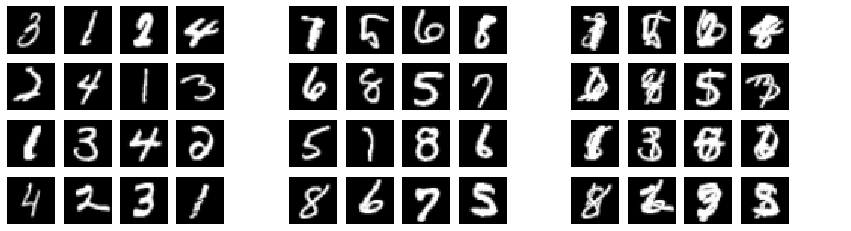

DRNets Separated Image


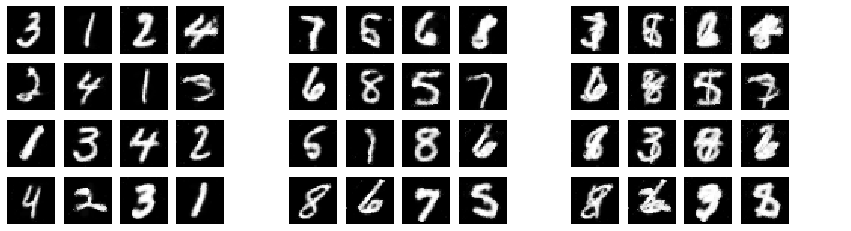

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.133072
epoch = 57, Iteration 0: total_loss: -1.252421, loss_recon: 0.131764, entropy_cell: 0.101544, entropy_alldiff: 1.385201

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


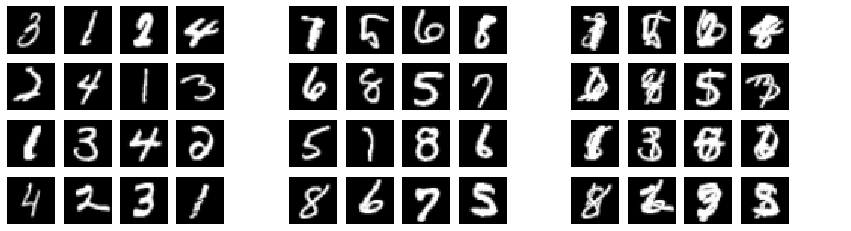

DRNets Separated Image


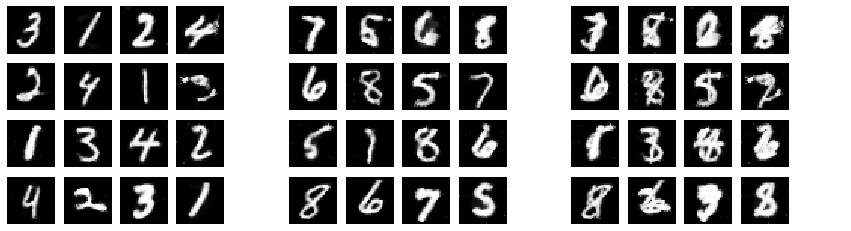

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.131764
epoch = 58, Iteration 0: total_loss: -1.249334, loss_recon: 0.136066, entropy_cell: 0.074872, entropy_alldiff: 1.386149

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


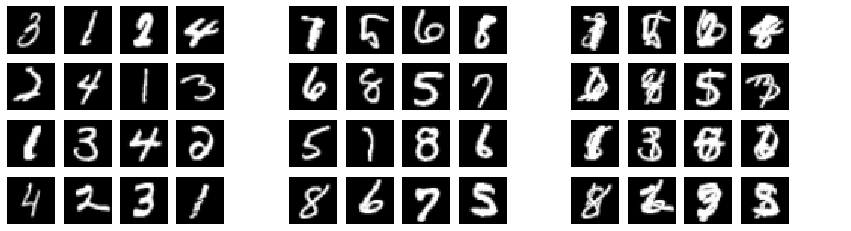

DRNets Separated Image


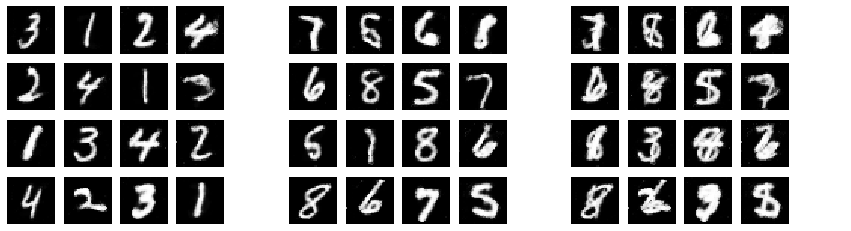

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.136066
epoch = 59, Iteration 0: total_loss: -1.252555, loss_recon: 0.131858, entropy_cell: 0.088972, entropy_alldiff: 1.385303

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


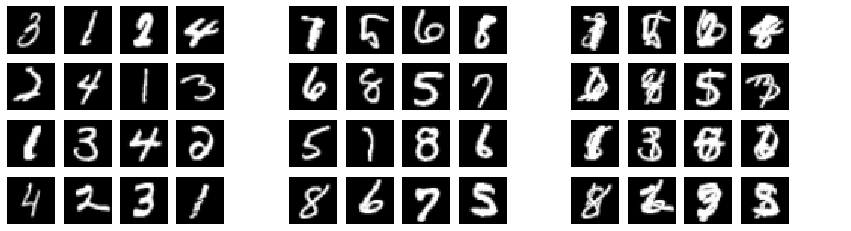

DRNets Separated Image


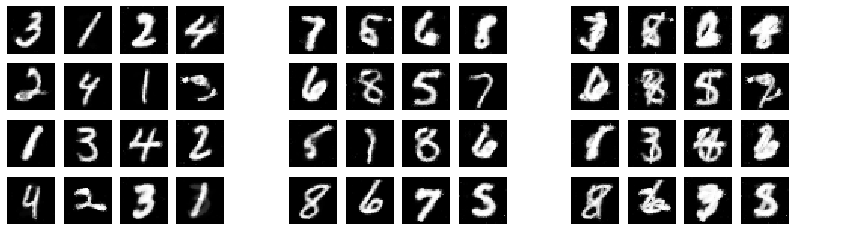

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.131858
epoch = 60, Iteration 0: total_loss: -1.252306, loss_recon: 0.133002, entropy_cell: 0.072257, entropy_alldiff: 1.386031

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


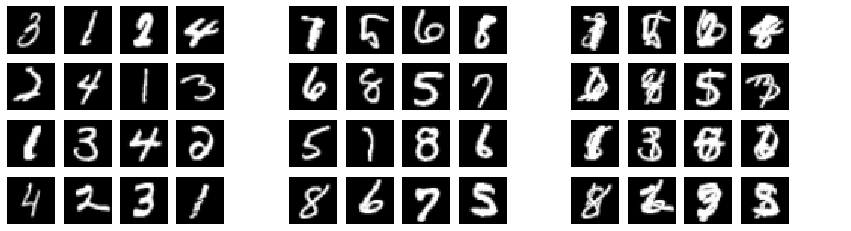

DRNets Separated Image


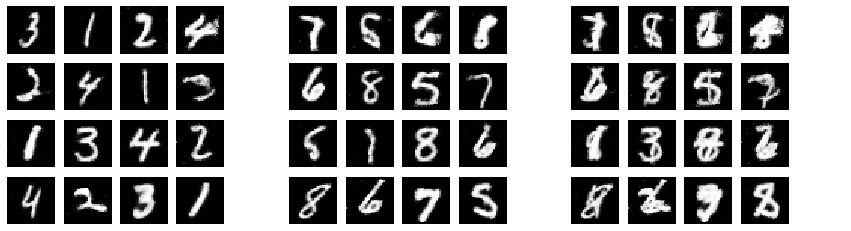

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.133002
epoch = 61, Iteration 0: total_loss: -1.252078, loss_recon: 0.133348, entropy_cell: 0.071883, entropy_alldiff: 1.386145

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


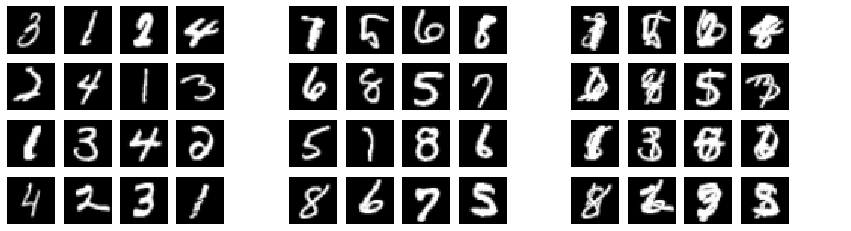

DRNets Separated Image


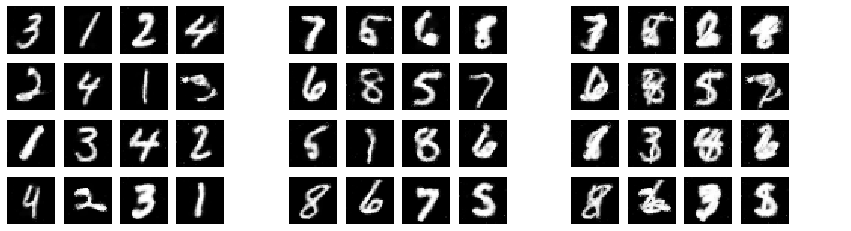

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.133348
epoch = 62, Iteration 0: total_loss: -1.240581, loss_recon: 0.130059, entropy_cell: 0.105640, entropy_alldiff: 1.371697

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


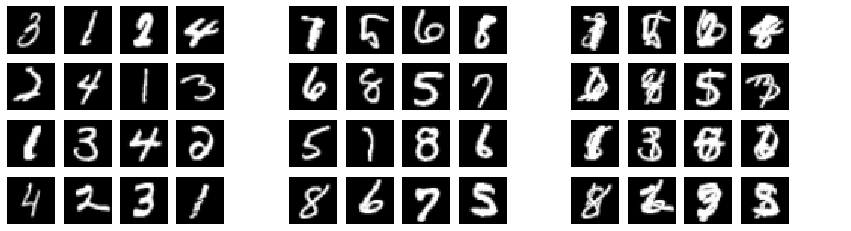

DRNets Separated Image


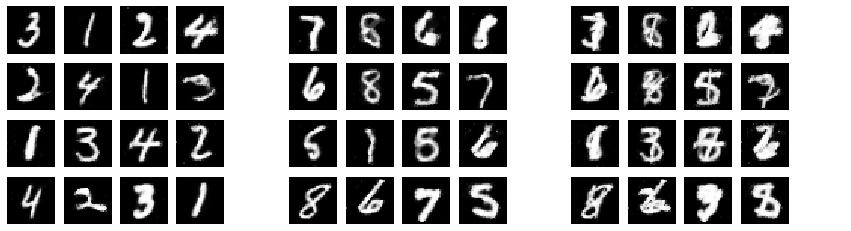

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,5,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.937500, recon_loss = 0.130059
epoch = 63, Iteration 0: total_loss: -1.254529, loss_recon: 0.130660, entropy_cell: 0.073175, entropy_alldiff: 1.385922

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


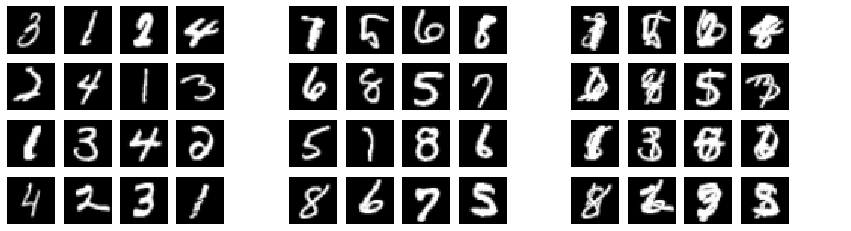

DRNets Separated Image


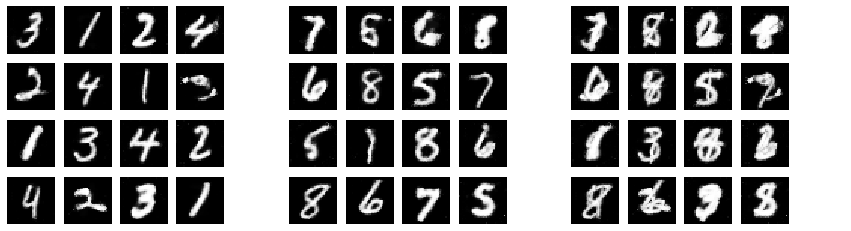

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.130660
epoch = 64, Iteration 0: total_loss: -1.251589, loss_recon: 0.129909, entropy_cell: 0.090743, entropy_alldiff: 1.382406

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


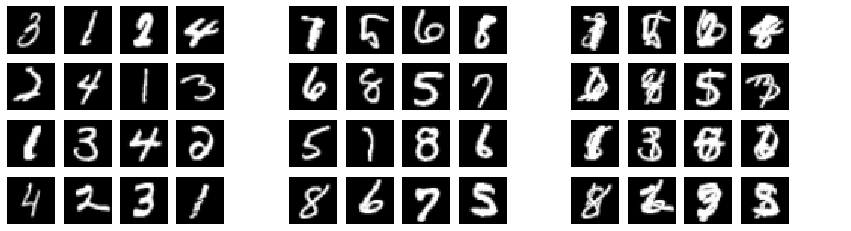

DRNets Separated Image


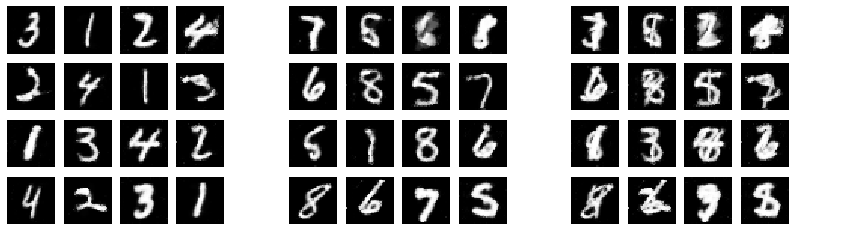

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.129909
epoch = 65, Iteration 0: total_loss: -1.255002, loss_recon: 0.130721, entropy_cell: 0.053868, entropy_alldiff: 1.386261

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


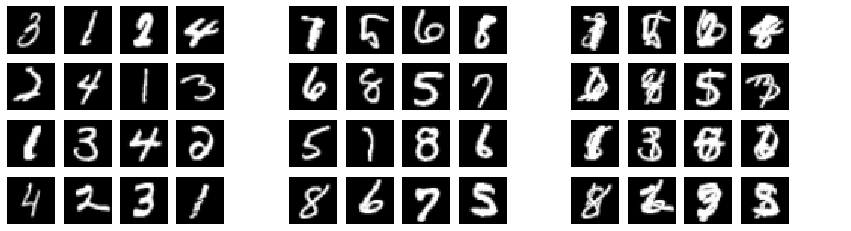

DRNets Separated Image


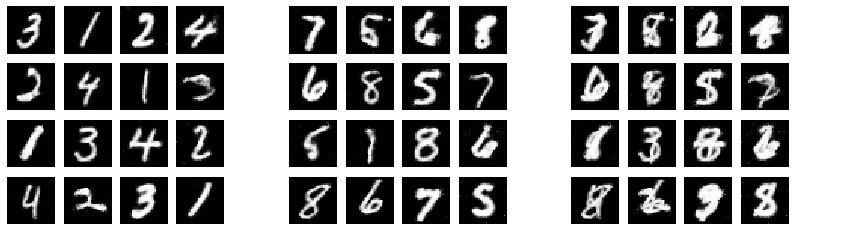

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.130721
epoch = 66, Iteration 0: total_loss: -1.249296, loss_recon: 0.131494, entropy_cell: 0.099252, entropy_alldiff: 1.381783

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


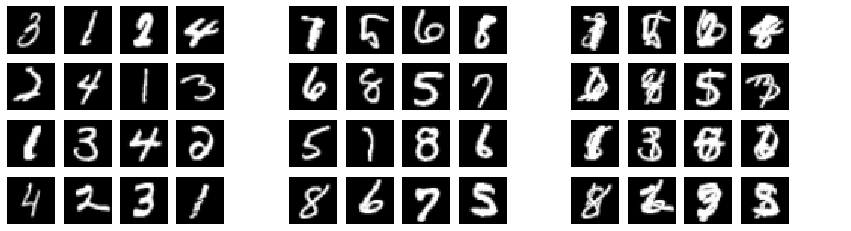

DRNets Separated Image


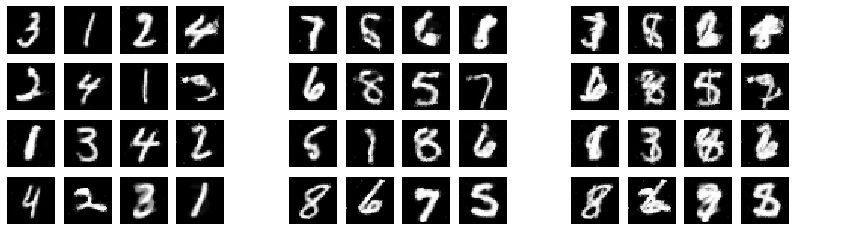

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.131494
epoch = 67, Iteration 0: total_loss: -1.256926, loss_recon: 0.127835, entropy_cell: 0.079954, entropy_alldiff: 1.385561

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


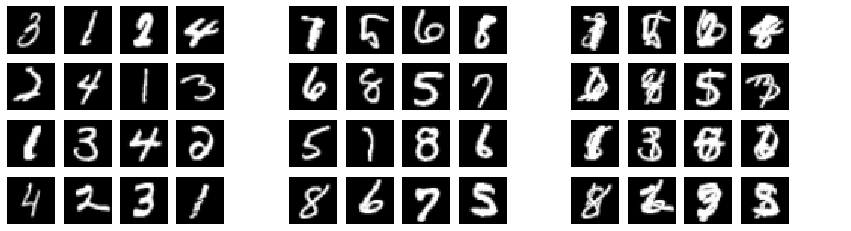

DRNets Separated Image


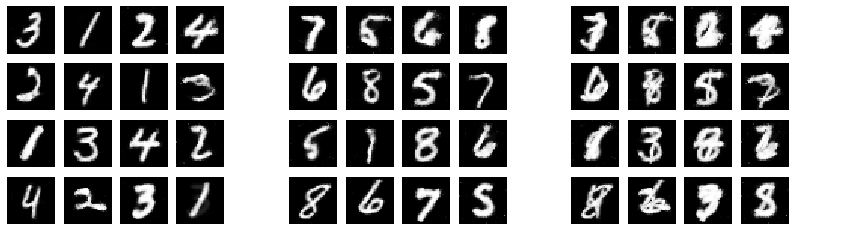

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.127835
epoch = 68, Iteration 0: total_loss: -1.258568, loss_recon: 0.126434, entropy_cell: 0.074981, entropy_alldiff: 1.385752

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


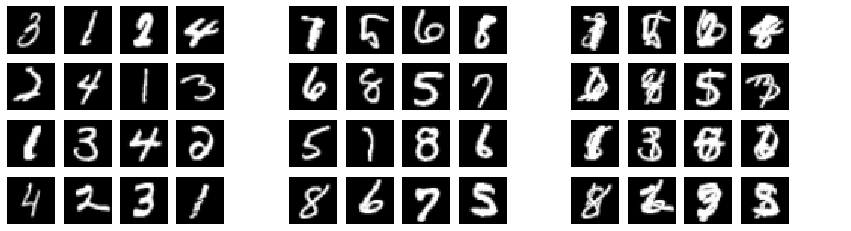

DRNets Separated Image


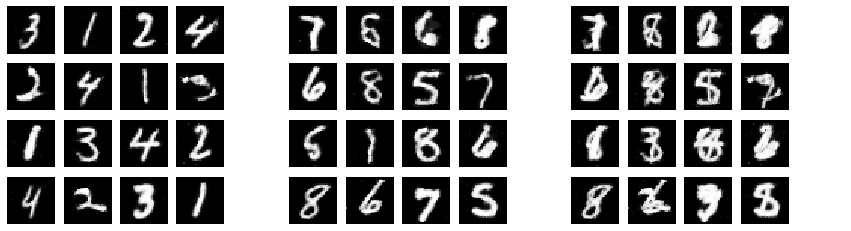

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.126434
epoch = 69, Iteration 0: total_loss: -1.254028, loss_recon: 0.128736, entropy_cell: 0.090368, entropy_alldiff: 1.383668

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


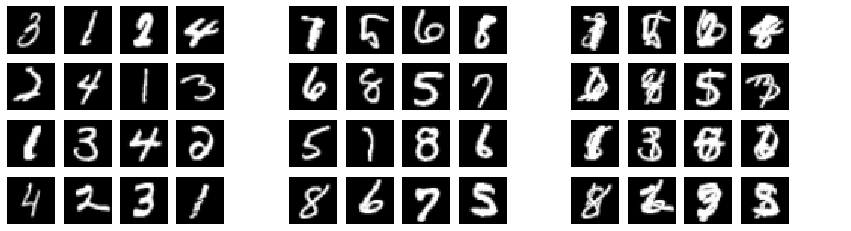

DRNets Separated Image


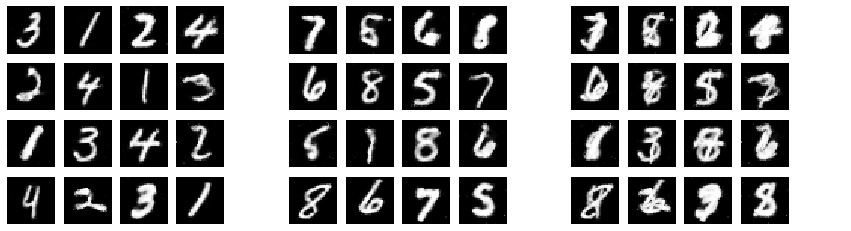

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.128736
epoch = 70, Iteration 0: total_loss: -1.255996, loss_recon: 0.128929, entropy_cell: 0.073492, entropy_alldiff: 1.385660

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


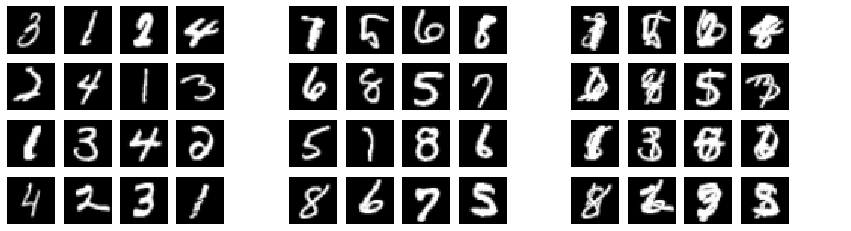

DRNets Separated Image


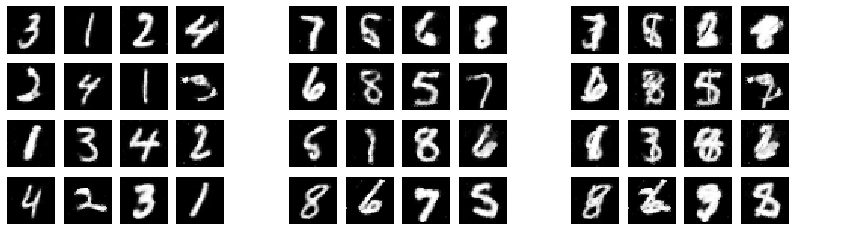

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.128929
epoch = 71, Iteration 0: total_loss: -1.257457, loss_recon: 0.128137, entropy_cell: 0.060866, entropy_alldiff: 1.386202

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


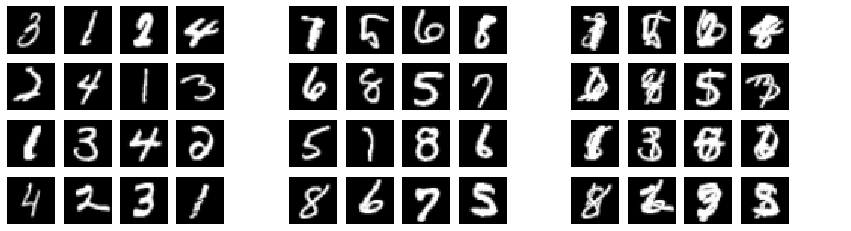

DRNets Separated Image


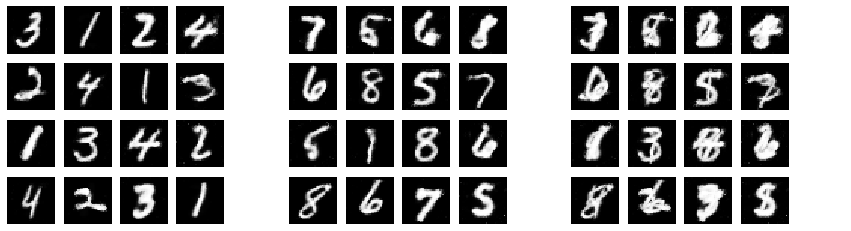

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.128137
epoch = 72, Iteration 0: total_loss: -1.259329, loss_recon: 0.125061, entropy_cell: 0.084612, entropy_alldiff: 1.385236

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


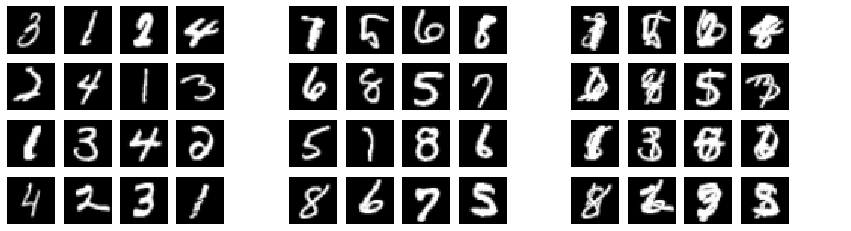

DRNets Separated Image


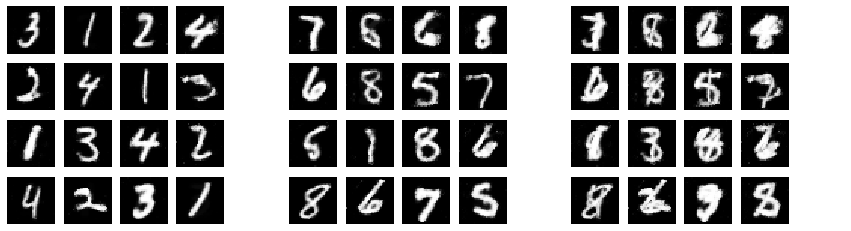

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.125061
epoch = 73, Iteration 0: total_loss: -1.256775, loss_recon: 0.128109, entropy_cell: 0.067699, entropy_alldiff: 1.385560

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


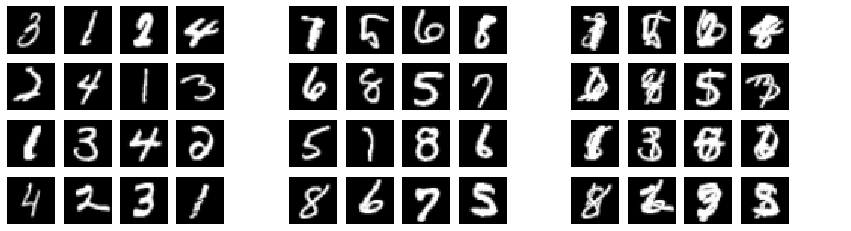

DRNets Separated Image


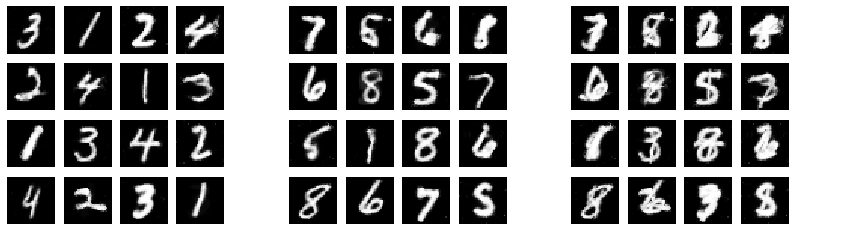

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.128109
epoch = 74, Iteration 0: total_loss: -1.257942, loss_recon: 0.127741, entropy_cell: 0.052336, entropy_alldiff: 1.386206

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


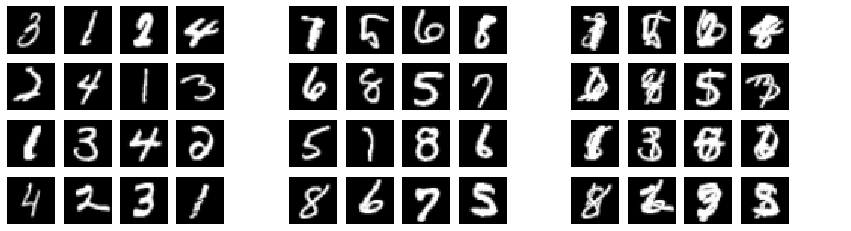

DRNets Separated Image


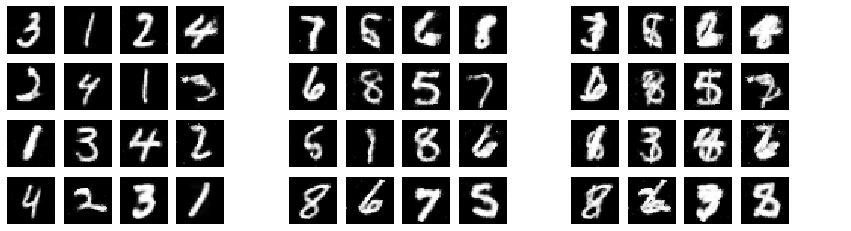

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.127741
epoch = 75, Iteration 0: total_loss: -1.252182, loss_recon: 0.124853, entropy_cell: 0.128164, entropy_alldiff: 1.378316

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


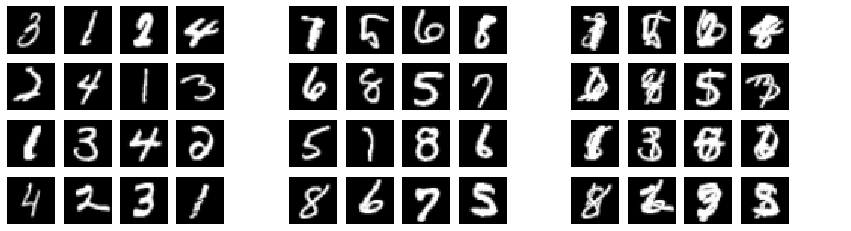

DRNets Separated Image


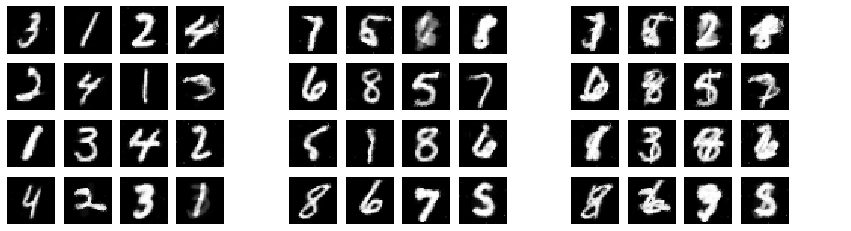

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.124853
epoch = 76, Iteration 0: total_loss: -1.260278, loss_recon: 0.125018, entropy_cell: 0.072375, entropy_alldiff: 1.386020

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


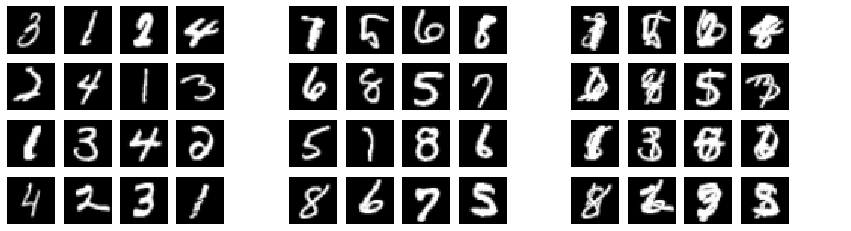

DRNets Separated Image


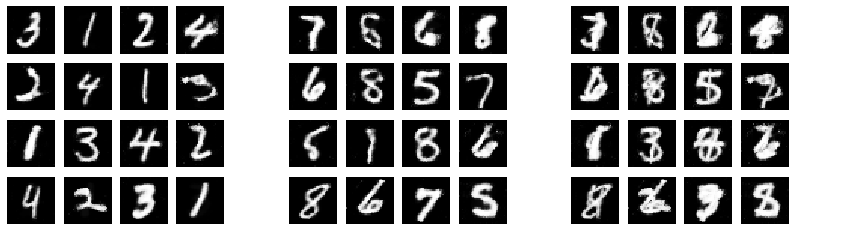

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.125018
epoch = 77, Iteration 0: total_loss: -1.253839, loss_recon: 0.120721, entropy_cell: 0.106891, entropy_alldiff: 1.375628

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


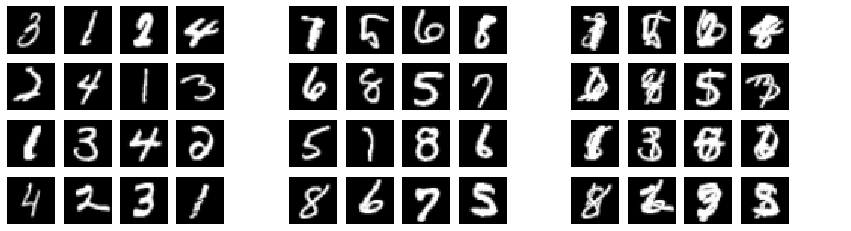

DRNets Separated Image


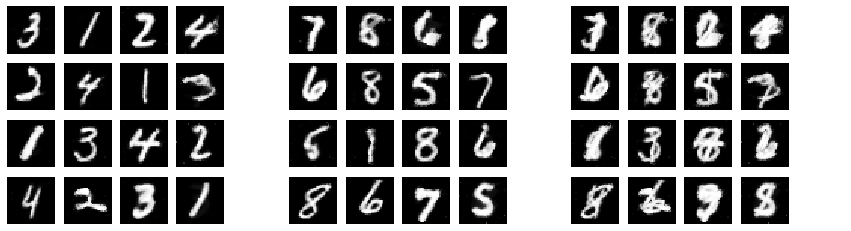

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,8,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 0.000000, label_acc = 0.937500, recon_loss = 0.120721
epoch = 78, Iteration 0: total_loss: -1.257704, loss_recon: 0.127584, entropy_cell: 0.070355, entropy_alldiff: 1.385992

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


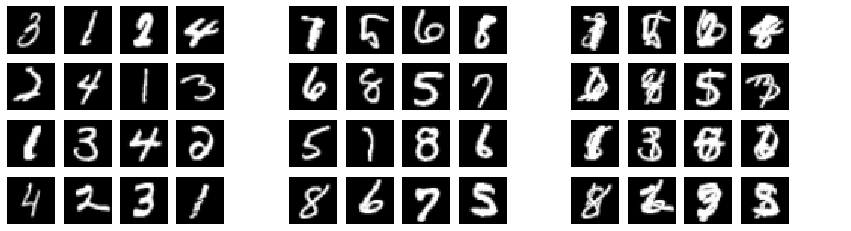

DRNets Separated Image


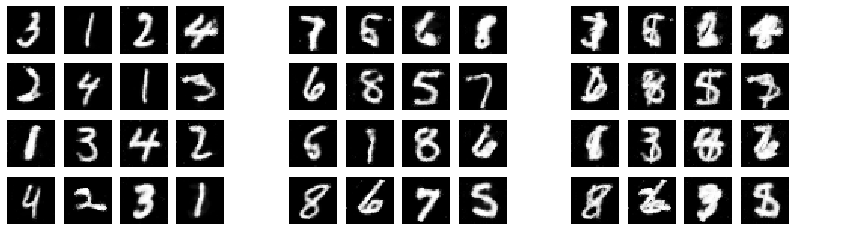

ground-truth labels
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
DRNets' predictions
3,1,2,4, 7,5,6,8,
2,4,1,3, 6,8,5,7,
1,3,4,2, 5,7,8,6,
4,2,3,1, 8,6,7,5,
#puzzle = 1, sudoku_acc = 1.000000, label_acc = 1.000000, recon_loss = 0.127584
epoch = 79, Iteration 0: total_loss: -1.258511, loss_recon: 0.121960, entropy_cell: 0.095797, entropy_alldiff: 1.381429

Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku
GroundTruth Images


KeyboardInterrupt: 

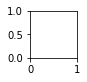

In [6]:
base1 = 1
base2 = 5 
n_data = sudoku.shape[0]
n_col = 4
n_row = 4
nums = 4
sep = resnet18(predictor=False)
pred = resnet18(predictor=True)
use_cuda = torch.cuda.is_available()

sep = resnet18(predictor=False)
pred = resnet18(predictor=True)

################################he hyper-parameters you may want to play with ########################
lr = 0.0001
optimizer_steps = 100
batch_size = 1
check_freq = n_data // batch_size
scale_recon = 0.001
keep_p = 1.0
entropy_cell_penalty = 0.01
entropy_alldiff_penalty = 1.0
start_reasoning_step = 10
#####################################################################################################

alldiff_constraints = gen_alldiff_constraints(nums, batch_size) #bs * 12 * 4
gen_labels = torch.LongTensor(np.arange(nums ** 3 * 2 * batch_size, dtype = "int32") % (2 * nums) + base1)

if use_cuda:
    sep = sep.cuda()
    pred = pred.cuda()
    gen_labels =  gen_labels.cuda()
    print("use_cuda")

s_mix_lst = []
l1_lst = []
l2_lst = []
s1_lst = []
s2_lst = []


print ("Training Starts!")

for _epoch_ in range(optimizer_steps):
    all_sudoku_acc = 0
    all_label_acc = 0
    all_recon_loss = 0
    cnt = 0
    for idx in range(n_data):
    
        s1 = sudoku[idx]
        s2 = sudoku5678[idx]
        
        l1 = ori_label[idx]
        l2 = ori_label5678[idx]
        
        s1 = s1.reshape(nums, nums, 32, 32)
        s2 = s2.reshape(nums, nums, 32, 32)
        s_mix = np.maximum(s1, s2)
    
        s_mix = np.reshape(s_mix, (16, 1, 32, 32))
        
        #loading samples
        s_mix_lst.append(s_mix)
        l1_lst.append(l1)
        l2_lst.append(l2)
        s1_lst.append(s1)
        s2_lst.append(s2)
        
        if (len(s_mix_lst) == batch_size):
            s_mix = np.concatenate(s_mix_lst, axis = 0) # bs * 16, 1, 32, 32
            s_mix = Variable(torch.tensor(s_mix).float(), requires_grad=False)

            if use_cuda:
                s_mix = s_mix.cuda()
            
            epochs = 1
            for ii in range(epochs):
                
                labels1_distribution, labels2_distribution = pred(s_mix) #bs * 16, 4 

                if (use_cuda):
                    z = sep(torch.tensor(s_mix.reshape(-1, 1, 32, 32)).float()).cuda() #bs * 16, 2, 4, 100
                else:
                    z = sep(torch.tensor(s_mix.reshape(-1, 1, 32, 32)).float())

                optimizer = torch.optim.Adam(list(pred.parameters()) + list(sep.parameters()), lr=lr)
                
                # compute accs
                labels1 = labels1_distribution.cpu().data.numpy()
                labels2 = labels2_distribution.cpu().data.numpy()
                
                labels1_argmax = np.argmax(labels1, axis=1)
                labels2_argmax = np.argmax(labels2, axis=1)

                labels12 = np.concatenate([(labels1_argmax + base1).reshape(-1, 1), (labels2_argmax + base2).reshape(-1, 1)], axis = 1)
                
                l1 = np.concatenate(l1_lst, axis = 0)
                l2 = np.concatenate(l2_lst, axis = 0)
                
                l12 = np.concatenate([l1.reshape(-1, 1), l2.reshape(-1, 1)], axis = 1) # bs * 16, 2
                
                
                eqn = np.equal(labels12, l12).astype("int").reshape(batch_size, nums**2, 2)
                
                label_acc = np.mean((np.sum(eqn, axis = 2) == 2).astype("float32"))
                sudoku_acc = np.mean((np.sum(eqn, axis = (1,2)) == 32).astype("float32"))
                
                # compute mixture
                gen_imgs = generator(z.view(-1, 100), gen_labels) #bs*16*2*4, 1, 32, 32

                label_distribution = torch.cat([labels1_distribution, labels2_distribution], dim = 1) # bs * 16 * 8

                gen_mix = gen_imgs.permute(1, 2, 3, 0) * label_distribution.view(-1)

                gen_mix = gen_mix.view(1, 32, 32, batch_size * 16, 2, 4)

                gen_mix = torch.sum(gen_mix, dim = 5) # avg by distribution 1, 32, 32, bs*16, 2

                gen_img_demix = gen_mix.permute(3, 4, 0, 1, 2) # bs*16, 2, 32, 32 #only used for visualization

                gen_mix = torch.max(gen_mix, dim = 4)[0]

                gen_mix = gen_mix.permute(3, 0, 1, 2).view(-1, 32, 32) #bs * 16, 32, 32

                cri = torch.nn.L1Loss(reduction="sum")

                loss_recon = 0.

                loss_recon = cri(s_mix.view(-1, 32, 32), gen_mix)

                loss_recon /= (1.0 * labels1_distribution.size(0))
                
                #compute the entropy-based cardinality constraint losses 
                entropy_cell = 0.5 * (entropy(labels1_distribution) + entropy(labels2_distribution))
                
                #compute the entropy-based ALL-Diff constraint losses 
                all_diff_loss1 = entropy(torch.mean(labels1_distribution[torch.LongTensor(alldiff_constraints)], dim = 1))
                all_diff_loss2 = entropy(torch.mean(labels2_distribution[torch.LongTensor(alldiff_constraints)], dim = 1))
                entropy_alldiff = 0.5 * (all_diff_loss1 + all_diff_loss2) 

                drop_out_recon = torch.nn.Dropout(p = 1.0 - keep_p)
                drop_out_cell = torch.nn.Dropout(p = 1.0 - keep_p)
                drop_out_alldiff = torch.nn.Dropout(p = 1.0 - keep_p)

                loss_recon = drop_out_recon(loss_recon)
                entropy_cell_drop = drop_out_cell(entropy_cell)
                entropy_alldiff_drop = drop_out_alldiff(entropy_alldiff)

                if (_epoch_ < start_reasoning_step):
                    loss = scale_recon * loss_recon
                else:
                    loss = scale_recon * loss_recon +  entropy_cell_penalty * entropy_cell_drop - entropy_alldiff_penalty * (entropy_alldiff_drop)
            
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

                if (ii % 100 == 0 and (cnt + 1) % check_freq == 0):
                    
                    print ("epoch = %d, Iteration %d: total_loss: %f, loss_recon: %f, entropy_cell: %f, entropy_alldiff: %f\n" % \
                        (_epoch_, idx, loss.item(), scale_recon * loss_recon.item(), entropy_cell.item(),  entropy_alldiff.item()))
                    print ("Below is the visulation for the image, and it follows the order from left to right: 1. seperate sudoku1 2. seperate sudoku2 3. mixed sudoku")
                    print ("GroundTruth Images")
                    show_sudoku(s1_lst[0], s2_lst[0], np.reshape(s_mix_lst[0], (4, 4, 32, 32)), "s1")
                    
                    print ("DRNets Separated Image")
                    gen_imgs1_numpy = np.concatenate([item.cpu().data.numpy() for item in gen_img_demix[:nums**2,0]])
                    gen_imgs1_numpy = np.reshape(gen_imgs1_numpy, (4, 4, 32, 32))

                    gen_imgs2_numpy = np.concatenate([item.cpu().data.numpy() for item in gen_img_demix[:nums**2,1]])
                    gen_imgs2_numpy = np.reshape(gen_imgs2_numpy, (4, 4, 32, 32))

                    gen_mix_numpy = np.concatenate([item.cpu().data.numpy() for item in gen_mix[:nums**2]])
                    gen_mix_numpy = np.reshape(gen_mix_numpy, (4, 4, 32, 32))
                    
                    show_sudoku(gen_imgs1_numpy, gen_imgs2_numpy, gen_mix_numpy)
                    
                    print("ground-truth labels")
                    for i in range(4):
                        for j in range(4):
                            print(l1[i*4 + j], end = ",")
                        print(" ", end = "")

                        for j in range(4):
                            print(l2[i*4 + j], end = ",")
                        print("")
                        
                    print("DRNets' predictions")
                    for i in range(4):
                        for j in range(4):
                            print(labels1_argmax[i*4 + j] + base1, end = ",")
                        print(" ", end = "")

                        for j in range(4):
                            print(labels2_argmax[i*4 + j] + base2, end = ",")
                        print("")

            
            s_mix_lst = []
            l1_lst = []
            l2_lst = []
            s1_lst = []
            s2_lst = []
                 
            all_label_acc += label_acc
            all_sudoku_acc += sudoku_acc
            all_recon_loss += scale_recon * loss_recon.item()
            cnt += 1
        
            if (cnt % check_freq == 0):

                print("#puzzle = %d, sudoku_acc = %f, label_acc = %f, recon_loss = %f"%(cnt * batch_size, all_sudoku_acc/cnt, all_label_acc/cnt, all_recon_loss/cnt))
                cnt = 0
                all_label_acc = 0
                all_sudoku_acc = 0
                all_recon_loss = 0

                sys.stdout.flush()